# Index



**1. [Feature Scaling](#featurescaling)**  
**2. [DBSCAN Multivariate Outliers](#dbscanmultivariateoutliers)**  
**3. [Feature Selection](#featureselection)**  
   - 3.1. [Correlation Analysis](#correlationanalysisfeatureselection)  
   - 3.2. [Variance Analysis](#varianceanalysis)  

**4. [Cluster Analysis](#clusteranalysis)**  
   - 4.1. [Behaviour Based Segmentation](#behaviourbasedsegmentation)  

**5. [Customer Profiling](#customerprofiling)**  
   - 5.1. [Profiling with Numerical Data](#profilingwithnumericaldata)  
     - 5.1.1. [Cluster Size Analysis](#clustersizeanalisys)  
     - 5.1.2. [Cluster Mean vs Overall Mean](#clustermeanvsoverallmean)  
     - 5.1.3. [Age Distribution and Analysis per Cluster](#agedistributionandanalysispercluster)  
   - 5.2. [Profiling with Categorical Data](#profilingwithcategoricaldata)  
     - 5.2.1. [Geographic Analysis](#geographicalanalysis)  
     - 5.2.2. [Distribution Channel](#distributionchannelanalysis)  
     - 5.2.3. [Request Analysis](#requestanalysis)  
     - 5.2.4. [Booking Window Analysis](#bookingwindowanalysis)  
   - 5.3. [Disengaged Customers Profiling](#disengagedcustomersprofiling)  
     - 5.3.1. [Geographic Analysis](#disengagedcustomersgeographicalanalysis)  
     - 5.3.2. [Age Analysis](#disengagedcustomersageanalysis)  
     - 5.3.3. [Combining Age and Geographical Analysis](#combiningageandgeographicalanalysis)  


In [1]:
# Data manipulation
import pandas as pd  # For handling data in DataFrames
import numpy as np  # For numerical operations

# Data visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization

# Machine Learning - Preprocessing
from sklearn.preprocessing import MinMaxScaler  # For feature scaling

# Machine Learning - Clustering
from sklearn.cluster import KMeans  # K-Means clustering
from sklearn.cluster import DBSCAN  # DBSCAN clustering
from sklearn.neighbors import NearestNeighbors  # For nearest neighbor calculations

# Machine Learning - Evaluation
from sklearn.metrics import silhouette_score  # To evaluate clustering performance

# Datasets (for testing)
from sklearn.datasets import make_blobs  # Generates sample data for clustering

# Utilities
from collections import Counter  # For counting elements in clusters


In [92]:
# Defining Functions

def assign_segment(country, continent, top_5_countries):
    """
    Assigns a segment based on whether a country is in the top 5.
    """
    if country in top_5_countries:
        return country
    else:
        return continent
    
    

def corr_pairs(corr, threshold):
    mask = np.tril(np.ones(corr.shape), k=-1).astype(bool)
    
    corr_lower = corr.where(mask)
    
    cor_pairs = corr_lower.unstack().dropna()
    cor_pairs = cor_pairs[(cor_pairs.abs() >= threshold)]

    
    for pair, value in cor_pairs.items():
        feature_count_pair1 = len(corr[(corr[pair[0]].abs() > 0.35) & (corr[pair[0]].abs() < threshold)])
        feature_count_pair2 = len(corr[(corr[pair[1]].abs() > 0.35) & (corr[pair[1]].abs() < threshold)])
        
        print(f'{value:.2f} : {pair[0]} | significantly correlated with {feature_count_pair1} more features | or | {pair[1]} | significantly correlated with {feature_count_pair2} more features')
        

# Apply the tourism type logic
def assign_tourism_type(row):
    if row["CountryName"] == "Portugal":
        return "National Tourism"
    elif row["Continent"] == "Europe":
        return "European Tourism"
    else:
        return "International Tourism"        
    
    
    
    

In [93]:
df = pd.read_csv("final_df.csv")

In [94]:
df.head()

,ID,Nationality,Age,DaysSinceCreation,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,TotalRevenue,RevenuePerBooking,TotalRequests,CheckInRate,FallBackRate,Frequency (Days),AveragePersonPerRoom,Tourism Segment 1,Tourism Segment 2,BookingWindow
0,1,PRT,52,440,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,0,...,374.3,187.15,0,0.67,0.33,220.0,1.5,Portugal,National Tourism,31-90 Getaways
1,4,FRA,61,1385,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,0,...,300.0,300.00,0,1.00,0.00,1385.0,2.0,France,European Tourism,91-180 Planners
2,6,JPN,55,1385,0x506065FBCE220DCEA4465C7310A84F04165BCB5906DC...,58,230.0,24.0,0,0,...,254.0,254.00,0,1.00,0.00,1385.0,2.0,Asia,International Tourism,31-90 Getaways
3,8,FRA,33,1385,0x6BB66BA80C726B9967988A889D83699B609D11C65AD7...,38,535.0,94.0,0,0,...,629.0,629.00,1,1.00,0.00,1385.0,2.0,France,European Tourism,31-90 Getaways
4,10,IRL,26,1385,0x199C61A5442D08987001E170B74D244DF6AF1FC9AE92...,96,174.0,69.0,0,0,...,243.0,243.00,0,1.00,0.00,1385.0,2.0,Europe,European Tourism,91-180 Planners


<a class="anchor" id="featurescaling"></a>
# [1. Feature Scaling](#Index)

In [95]:
# Select numerical columns and exclude those starting with "SR"
all_numerical_columns = [
    col for col in df.select_dtypes(include=[np.number]).columns 
    if not col.startswith("SR") and col != "ID"
]

In [96]:
all_numerical_columns

['Age',
 'DaysSinceCreation',
 'AverageLeadTime',
 'LodgingRevenue',
 'OtherRevenue',
 'BookingsCanceled',
 'BookingsNoShowed',
 'BookingsCheckedIn',
 'PersonsNights',
 'RoomNights',
 'TotalRevenue',
 'RevenuePerBooking',
 'TotalRequests',
 'CheckInRate',
 'FallBackRate',
 'Frequency (Days)',
 'AveragePersonPerRoom']

In [97]:
# Normalize the data using MinMaxScaler directly in the df
scaler = MinMaxScaler()
df[all_numerical_columns] = scaler.fit_transform(df[all_numerical_columns])


df_numeric = df[all_numerical_columns].copy()

df_numeric

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,TotalRevenue,RevenuePerBooking,TotalRequests,CheckInRate,FallBackRate,Frequency (Days),AveragePersonPerRoom
0,0.531250,0.299481,0.119433,0.030158,0.022986,0.066667,0.0,0.012821,0.039683,0.024194,0.031373,0.015686,0.00,0.507463,0.492537,0.153343,0.100
1,0.625000,1.000000,0.188259,0.024787,0.016757,0.000000,0.0,0.000000,0.071429,0.032258,0.025145,0.025145,0.00,1.000000,0.000000,1.000000,0.200
2,0.562500,1.000000,0.117409,0.023754,0.006703,0.000000,0.0,0.000000,0.023810,0.008065,0.021290,0.021290,0.00,1.000000,0.000000,1.000000,0.200
3,0.333333,1.000000,0.076923,0.055255,0.026253,0.000000,0.0,0.000000,0.071429,0.032258,0.052721,0.052721,0.25,1.000000,0.000000,1.000000,0.200
4,0.260417,1.000000,0.194332,0.017971,0.019271,0.000000,0.0,0.000000,0.039683,0.016129,0.020368,0.020368,0.00,1.000000,0.000000,1.000000,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72339,0.500000,0.410675,0.042510,0.034599,0.017316,0.000000,0.0,0.025641,0.031746,0.032258,0.033276,0.011092,0.25,1.000000,0.000000,0.136628,0.000
72340,0.583333,0.802817,0.006073,0.189230,0.014244,0.000000,0.0,0.012821,0.063492,0.040323,0.157845,0.078923,0.25,1.000000,0.000000,0.400436,0.100
72341,0.468750,0.954781,0.234818,0.043688,0.016478,0.000000,0.0,0.012821,0.031746,0.024194,0.040400,0.020200,0.00,1.000000,0.000000,0.474564,0.050
72342,0.437500,0.472202,0.151822,0.065789,0.072336,0.000000,0.0,0.025641,0.079365,0.056452,0.075101,0.025034,0.25,1.000000,0.000000,0.156250,0.075


<a class="anchor" id="dbscanmultivariateoutliers"></a>
# [2 DBSCAN Multivariate Outliers](#Index)

- MinPts: As a rule of thumb, minPts = 2 x dim can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.
so minPts = 27*2 =54
- ε: The value for ε can then be chosen by using a k-distance graph, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an "elbow": if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. so k=45

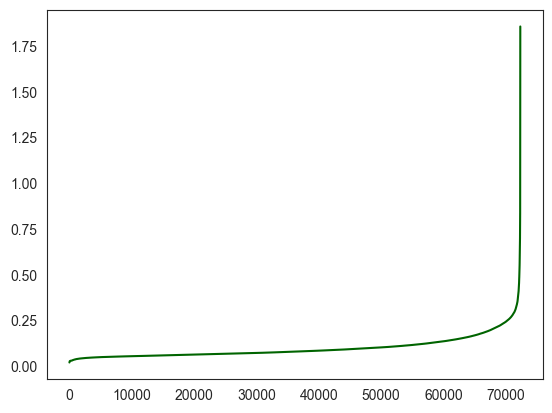

In [98]:
# K-distance graph to find out the right epsilon value
sns.set_style("white")
neigh = NearestNeighbors(n_neighbors=33)
neigh.fit(df_numeric)
distances, _ = neigh.kneighbors(df_numeric)
distances = np.sort(distances[:, -1])
plt.plot(distances, color='darkgreen')
plt.show()

In [99]:
dbscan = DBSCAN(eps=0.3, min_samples=34, n_jobs=8)
#n_jobs: limits the algorithm to use 8 cores, which can speed up computations for large datasets.
dbscan_labels = dbscan.fit_predict(df_numeric)
Counter(dbscan_labels)

Counter({np.int64(0): 72056, np.int64(-1): 288})

In [100]:
# Create a new column on the df_numeric 
df_numeric['dbscan_labels'] = dbscan_labels

In [101]:
# Verify if the number of outliers match
df_numeric[df_numeric['dbscan_labels'] == -1].shape[0]

288

In [102]:
# Add this column to the original dataframe so that we can also remove the outliers from this dataframe also.
df['dbscan_labels'] = df_numeric['dbscan_labels']

In [103]:
# # Verify if the number of outliers match
df[df['dbscan_labels'] == -1].shape[0]

288

In [104]:
# Remove rows with dbscan_labels == -1 in df_numeric
df_numeric= df_numeric[df_numeric['dbscan_labels'] != -1]

# Remove rows with dbscan_labels == -1 in df_other
df = df[df['dbscan_labels'] != -1]

In [105]:
# Eliminate this column, for the feature selection
df_numeric = df_numeric.drop("dbscan_labels", axis = 1)

In [106]:
df = df.drop("dbscan_labels", axis = 1)

<a class="anchor" id="featureselection"></a>
# [3 Feature Selection](#Index)

<a class="anchor" id="correlationanalysisfeatureselection"></a>
# [3.1 Correlation Analysis](#Index)

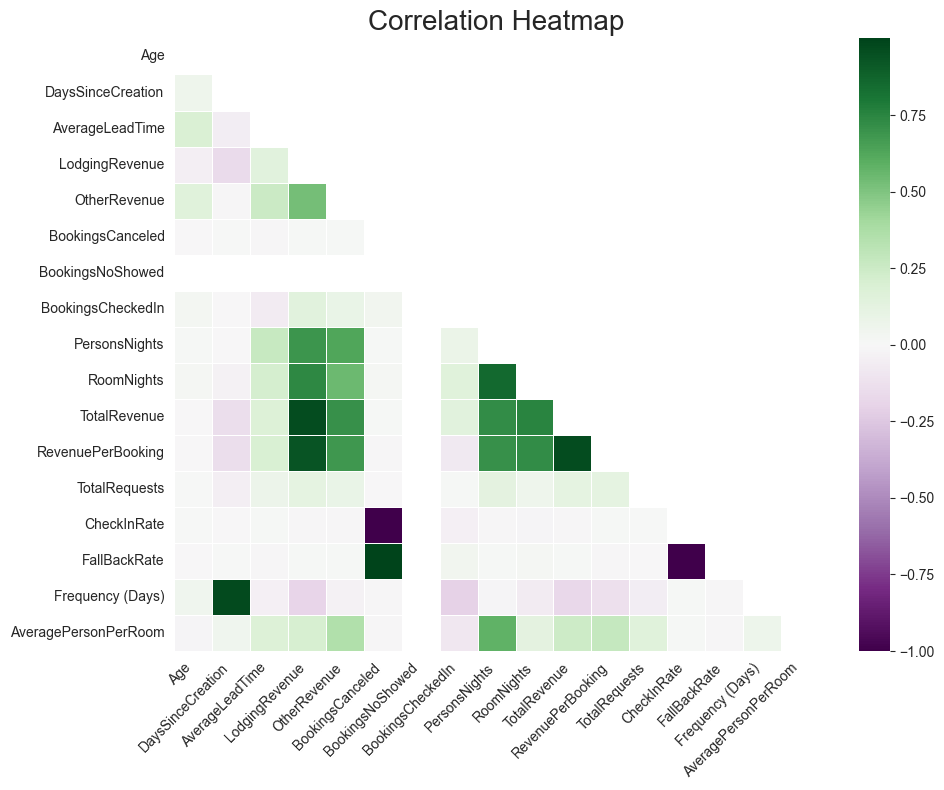

In [107]:
fig = plt.figure(figsize=(10, 8))

#Obtain correlation matrix. 
spearman = df_numeric.corr(method="spearman")
#Generating a mask for the upper triangle
mask = np.triu(np.ones_like(spearman, dtype=bool))

#Plot heatmap of the correlation matrix
sns.heatmap(data=spearman, mask=mask, annot=False, cmap='PRGn', cbar=True, square=False, linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  

plt.show()

In [108]:
corr_pairs(spearman, 0.70)

0.97 : DaysSinceCreation | significantly correlated with 0 more features | or | Frequency (Days) | significantly correlated with 0 more features
0.74 : LodgingRevenue | significantly correlated with 2 more features | or | RoomNights | significantly correlated with 1 more features
0.96 : LodgingRevenue | significantly correlated with 2 more features | or | TotalRevenue | significantly correlated with 0 more features
0.93 : LodgingRevenue | significantly correlated with 2 more features | or | RevenuePerBooking | significantly correlated with 1 more features
0.71 : OtherRevenue | significantly correlated with 5 more features | or | TotalRevenue | significantly correlated with 0 more features
-1.00 : BookingsCanceled | significantly correlated with 0 more features | or | CheckInRate | significantly correlated with 0 more features
1.00 : BookingsCanceled | significantly correlated with 0 more features | or | FallBackRate | significantly correlated with 0 more features
0.86 : PersonsNights |

<a class="anchor" id="varianceanalysis"></a>
# [3.2 Variance Analysis](#Index)

In [109]:
round(df_numeric.var(), 6)

Age                     0.025084
DaysSinceCreation       0.077581
AverageLeadTime         0.030459
LodgingRevenue          0.001369
OtherRevenue            0.000908
BookingsCanceled        0.000000
BookingsNoShowed        0.000000
BookingsCheckedIn       0.000028
PersonsNights           0.001168
RoomNights              0.000219
TotalRevenue            0.001235
RevenuePerBooking       0.001077
TotalRequests           0.029217
CheckInRate             0.000002
FallBackRate            0.000002
Frequency (Days)        0.075312
AveragePersonPerRoom    0.017502
dtype: float64

According to the feature selection, we decided to use the variables "AverageLeadTime," "Frequency (Days)," "OtherRevenue," "LodgingRevenue," and "RevenuePerBooking" for our clustering.

<a class="anchor" id="clusteranalysis"></a>
# [4. Cluster Analysis](#Index)

## **Behavioral Clustering (Booking & Spending Patterns)**
This clustering focuses on **how customers interact with the hotel**, including booking frequency, cancellations, and spending behavior.

### **📌 Relevant Features:**
- **AverageLeadTime** – How far in advance do they book?
- **LodgingRevenue** – How much do they spend on stays?
- **OtherRevenue** – How much do they spend on extras (food, spa, etc.)?
- **Frequency** – How much do they spend on extras (food, spa, etc.)?


### **✅ Why This Matters?**
This clustering helps identify different customer behaviors, such as:
- **High-value guests** who book and spend frequently.
- **Last-minute bookers** who need specific marketing strategies.

In [110]:
behaviour_perspective = [
            "AverageLeadTime", 'Frequency (Days)', "OtherRevenue", "LodgingRevenue", "RevenuePerBooking"]

In [111]:
# Defining Pespectives
df_behaviour = df_numeric[behaviour_perspective]

<a class="anchor" id="behaviourbasedsegmentation"></a>
# [4.1 Behaviour Based Segmentation](#Index)

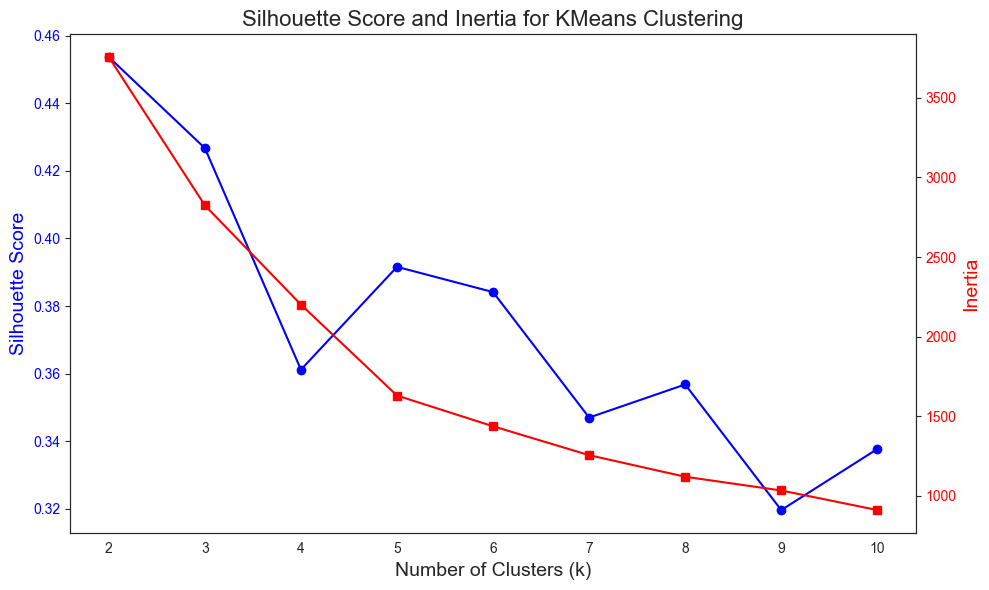

In [112]:
# Range of cluster values to test
k_range = range(2, 11)  # For example, test k=2 to k=10

sil_scores = []
inertia_values = []

# Loop over the k_range
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_behaviour)
    
    # Calculate Silhouette Score
    sil_score = silhouette_score(df_behaviour, kmeans.labels_)
    sil_scores.append(sil_score)
    
    # Get Inertia
    inertia_values.append(kmeans.inertia_)

# Plotting Silhouette Score and Inertia on the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Silhouette Score
ax1.plot(k_range, sil_scores, color='b', marker='o', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)', fontsize=14)
ax1.set_ylabel('Silhouette Score', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot Inertia
ax2 = ax1.twinx()
ax2.plot(k_range, inertia_values, color='r', marker='s', label='Inertia')
ax2.set_ylabel('Inertia', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r')

# Title and Show plot
plt.title('Silhouette Score and Inertia for KMeans Clustering', fontsize=16)
fig.tight_layout()
plt.show()

**K-Means with 4 or 5 Clusters seems like the best option**

In [113]:
# JUST RUN THIS CELL ONE TIME
df[all_numerical_columns] = scaler.inverse_transform(df[all_numerical_columns])

In [114]:
# Applying K-Means clustering with 4 clusters
kmeans_model = KMeans(n_clusters=4, init='k-means++', n_init=20, max_iter = 500 ,random_state=42)
df_behaviour['K_Means_4_Clusters_Behaviour_Labels'] = kmeans_model.fit_predict(df_behaviour)

C:\Users\victo\AppData\Local\Temp\ipykernel_13372\1617689255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_behaviour['K_Means_4_Clusters_Behaviour_Labels'] = kmeans_model.fit_predict(df_behaviour)


In [115]:
df["K_Means_4_Clusters_Behaviour_Labels"] = df_behaviour['K_Means_4_Clusters_Behaviour_Labels']

In [116]:
# Calculating the mean values for each cluster
cluster_means = df.groupby('K_Means_4_Clusters_Behaviour_Labels')[["AverageLeadTime", "Frequency (Days)",
                                                                  "OtherRevenue", "LodgingRevenue", "RevenuePerBooking"]].mean()

# Display the cluster means
cluster_means

,AverageLeadTime,Frequency (Days),OtherRevenue,LodgingRevenue,RevenuePerBooking
K_Means_4_Clusters_Behaviour_Labels,,,,,
0,190.733169,285.505460,115.847752,509.894170,597.352004
1,46.391103,1040.793637,82.621397,357.636483,440.257880
2,40.338004,380.635575,86.546687,440.225595,481.030653
3,214.094911,927.055510,109.389259,389.224765,498.126366


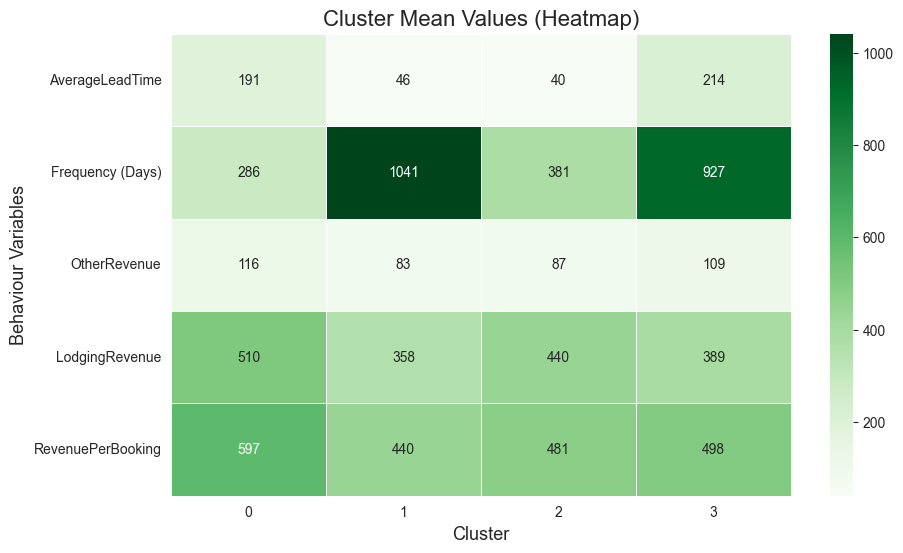

In [117]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, cmap='Greens', linewidths=0.5, fmt=".0f")

plt.title("Cluster Mean Values (Heatmap)", fontsize=16)
plt.xlabel("Cluster", fontsize=13)
plt.ylabel("Behaviour Variables", fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

Although 5 was the ideal number of clusters, our group chose to use 4 clusters, considering a marketing and strategic perspective. By selecting 4 clusters, we believe it allows for a clearer segmentation that aligns better with our target market. With fewer clusters, we can tailor our strategies more effectively, focusing on broader customer profiles that are easier to target in marketing campaigns. 

### Cluster Descriptions

#### **Cluster 0: High-Spending, High-Frequency Guests**
- These guests have the highest revenue per booking (597) and a relatively high lodging revenue (510).
- They book moderately in advance (AverageLeadTime: 191 days) and are the ones that visit more frequently (Frequency: 286 days).
- They also are the ones that generate the highest other revenue (116).

#### **Cluster 1: Infrequent Visitors, Budget-Conscious, last-minute travel.**
- This group visits the least frequently (1041 days) and has the lowest revenue per booking (440) and lodging revenue (358).
- Their other revenue is also the lowest (83), indicating they are cost-conscious travelers.
- They book trips with very short notice (AverageLeadTime: 46 days), suggesting last-minute travel habits.

#### **Cluster 2: Moderate-Spending, Frequent Visitors, last-minute travel.**
- These guests visit more frequently (Frequency: 381 days) and have mid-range revenue per booking (481) and lodging revenue (440).
- Their other revenue (87) is low, indicating they may not spend much beyond lodging.
- They also book with the shortest lead time (40 days), suggesting more spontaneous bookings.


#### **Cluster 3: High-Planning, Low-Frequency Visitors, High Other-Revenue Spenders**
- This group visits very infrequently (927 days) but plans their trips well in advance (AverageLeadTime: 214 days).
- Their revenue per booking (498) and lodging revenue (389) are moderate.
- Other revenue (109) suggests they engage in additional spending beyond lodging.


<a class="anchor" id="customerprofiling"></a>
# [5. Customer Profiling](#Index)

In [118]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
# Identify columns that start with 'SR'
sr_columns = [col for col in df.columns if col.startswith("SR")]
# Remove SR columns and 'ID' column from numerical_columns
numerical_columns = [col for col in numerical_columns if col not in sr_columns and col != "ID" and col!= "K_Means_4_Clusters_Behaviour_Labels"]



# Select categorical columns (object or string dtype)
categorical_columns = df.select_dtypes(include=[object, "string"]).columns.tolist()
# Use set() to avoid duplicates and then convert back to list
categorical_columns = list(set(categorical_columns) | set(sr_columns))
# Remove Hash columns, like ID and Name
categorical_columns = [col for col in categorical_columns if "Hash" not in col]

<a class="anchor" id="profilingwithnumericaldata"></a>
# [5.1 Profiling with numerical data](#Index)

In [119]:
numerical_columns

['Age',
 'DaysSinceCreation',
 'AverageLeadTime',
 'LodgingRevenue',
 'OtherRevenue',
 'BookingsCanceled',
 'BookingsNoShowed',
 'BookingsCheckedIn',
 'PersonsNights',
 'RoomNights',
 'TotalRevenue',
 'RevenuePerBooking',
 'TotalRequests',
 'CheckInRate',
 'FallBackRate',
 'Frequency (Days)',
 'AveragePersonPerRoom']

<a class="anchor" id="clustersizeanalisys"></a>
# [5.1.1 Cluster Size Analysis](#Index)

In [120]:
df["K_Means_4_Clusters_Behaviour_Labels"].value_counts()

K_Means_4_Clusters_Behaviour_Labels
2    26760
1    25019
0    10531
3     9746
Name: count, dtype: int64

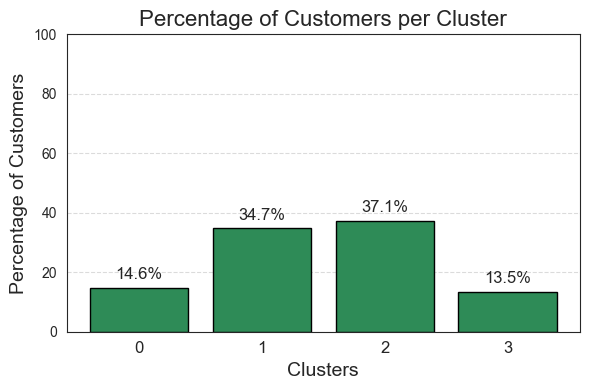

In [121]:


# Assuming df and 'K_Means_4_Clusters_Behaviour_Labels' are already defined
x = (df["K_Means_4_Clusters_Behaviour_Labels"].value_counts(normalize=True) * 100).index
y = (df["K_Means_4_Clusters_Behaviour_Labels"].value_counts(normalize=True) * 100).values

# Create the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(x, y, color='seagreen', edgecolor='black')

# Add percentage labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

# Labeling the axes and the title
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Percentage of Customers', fontsize=14)
plt.title('Percentage of Customers per Cluster', fontsize=16)

# Explicitly set x-ticks to match the cluster values
plt.xticks(x, labels=x, rotation=0, fontsize=12)

# Set the y-axis limit from 0 to 100 for percentage
plt.ylim(0, 100)

# Add horizontal gridlines for easier reading of percentages
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


<a class="anchor" id="clustermeanvsoverallmean"></a>
# [5.1.2 Cluster mean vs Overall mean](#Index)

In [122]:
group_means = df.groupby('K_Means_4_Clusters_Behaviour_Labels')[numerical_columns].mean().T
group_means

K_Means_4_Clusters_Behaviour_Labels,0,1,2,3
Age,51.139968,47.351013,45.516293,52.630823
DaysSinceCreation,304.610578,1040.793637,417.091854,928.084855
AverageLeadTime,190.733169,46.391103,40.338004,214.094911
LodgingRevenue,509.894170,357.636483,440.225595,389.224765
OtherRevenue,115.847752,82.621397,86.546687,109.389259
BookingsCanceled,0.000000,0.000000,0.000224,0.000000
BookingsNoShowed,0.000000,0.000000,0.000000,0.000000
BookingsCheckedIn,1.073023,1.000000,1.140658,1.001642
PersonsNights,7.588738,5.985771,6.038378,7.133080
RoomNights,3.643624,2.959831,3.242750,3.406628


In [123]:
overall_mean = pd.DataFrame(df[numerical_columns].mean()).rename(columns={0: 'Overall_Mean'})
overall_mean

,Overall_Mean
Age,47.937521
DaysSinceCreation,686.326787
AverageLeadTime,87.921672
LodgingRevenue,414.833243
OtherRevenue,92.555713
BookingsCanceled,0.000083
BookingsNoShowed,0.000000
BookingsCheckedIn,1.063131
PersonsNights,6.394762
RoomNights,3.225269


In [124]:
# Concatenate the two DataFrames horizontally
result = pd.concat([group_means, overall_mean], axis=1)
#result.columns = list(result.columns[:-1]) + ['Overall Mean']

result

,0,1,2,3,Overall_Mean
Age,51.139968,47.351013,45.516293,52.630823,47.937521
DaysSinceCreation,304.610578,1040.793637,417.091854,928.084855,686.326787
AverageLeadTime,190.733169,46.391103,40.338004,214.094911,87.921672
LodgingRevenue,509.894170,357.636483,440.225595,389.224765,414.833243
OtherRevenue,115.847752,82.621397,86.546687,109.389259,92.555713
BookingsCanceled,0.000000,0.000000,0.000224,0.000000,0.000083
BookingsNoShowed,0.000000,0.000000,0.000000,0.000000,0.000000
BookingsCheckedIn,1.073023,1.000000,1.140658,1.001642,1.063131
PersonsNights,7.588738,5.985771,6.038378,7.133080,6.394762
RoomNights,3.643624,2.959831,3.242750,3.406628,3.225269


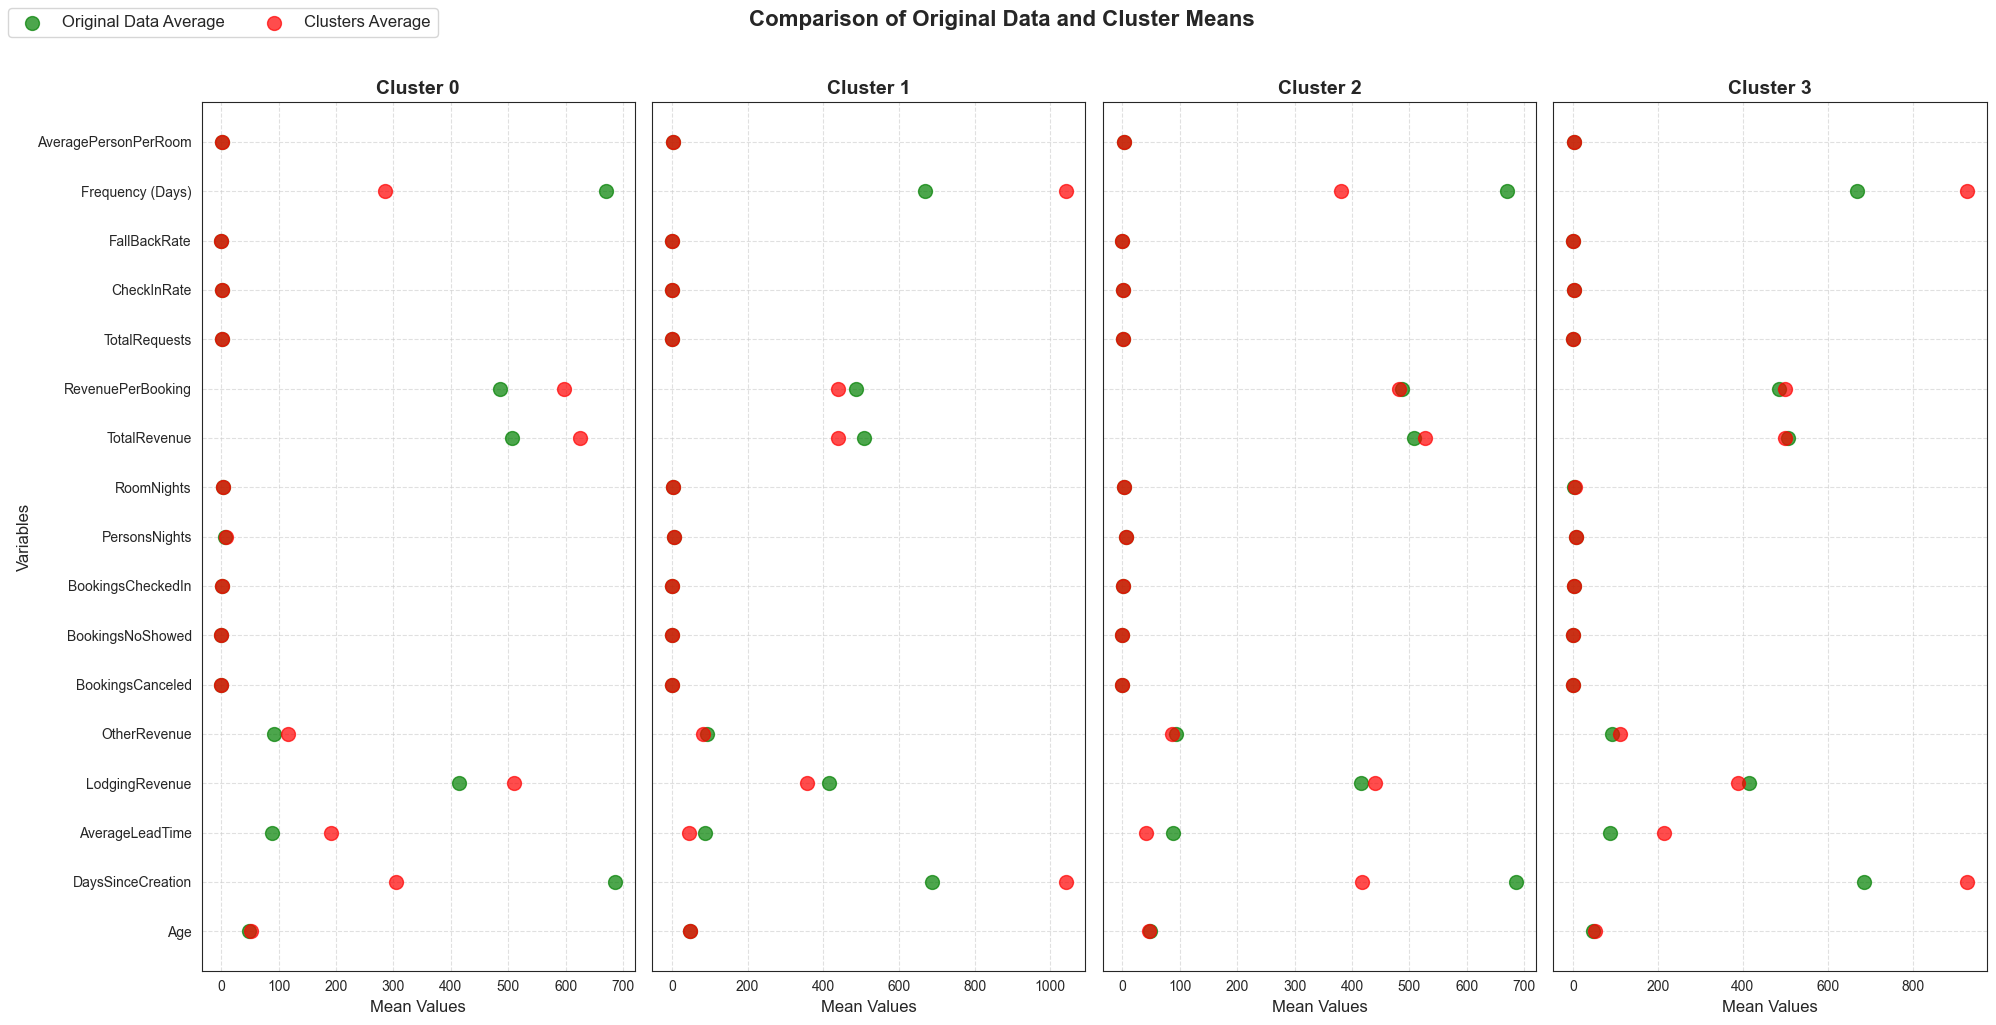

In [125]:
original_data_means = result['Overall_Mean']
cluster_means = {
    0: result[0],
    1: result[1],
    2: result[2],
    3: result[3]
}

# Variables (replace with your variable names)
variables = result.index.to_list()

# Plotting
fig, axes = plt.subplots(1, len(cluster_means), figsize=(20, 10), sharey=True)

for cluster, ax in zip(cluster_means.keys(), axes):
    # Scatter plot for the database means
    ax.scatter(original_data_means, variables, color='green', label='Original Data Average', s=100, alpha=0.7)
    
    # Scatter plot for the cluster means
    ax.scatter(cluster_means[cluster], variables, color='red', label=f'Clusters Average', s=100, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'Cluster {cluster}', fontsize=14, weight='bold')
    ax.set_xlabel('Mean Values', fontsize=12)
    if cluster == 0:
        ax.set_ylabel('Variables', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Add a shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=12)  # Change the location here

# Add a main title
fig.suptitle('Comparison of Original Data and Cluster Means', fontsize=16, weight='bold', y=1.02)

plt.tight_layout()
plt.show()

<a class="anchor" id="agedistributionandanalysispercluster"></a>
# [5.1.3 Age distribution and analysis per cluster](#Index)

In [126]:
mean_age_per_cluster = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["Age"].mean()
print(mean_age_per_cluster)

K_Means_4_Clusters_Behaviour_Labels
0    51.139968
1    47.351013
2    45.516293
3    52.630823
Name: Age, dtype: float64


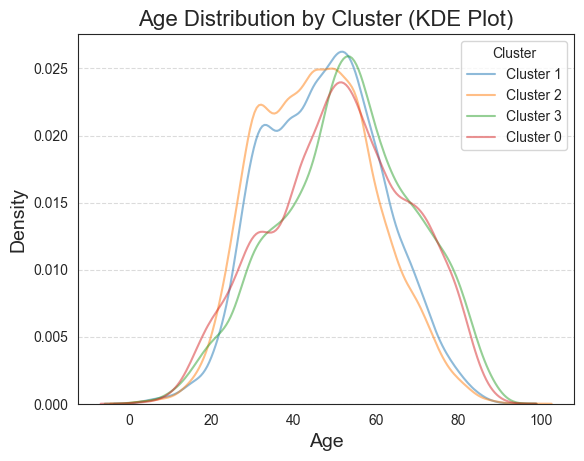

In [127]:
# Loop through each unique cluster and plot KDE for age
for cluster in df["K_Means_4_Clusters_Behaviour_Labels"].unique():
    subset = df[df["K_Means_4_Clusters_Behaviour_Labels"] == cluster]
    sns.kdeplot(subset["Age"], label=f"Cluster {cluster}", fill=False, alpha=0.5)

# Labels and title
plt.xlabel("Age", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Age Distribution by Cluster (KDE Plot)", fontsize=16)
plt.legend(title="Cluster")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

Despite the averages being very similar, clusters 1 and 2 have more young clients.

These two clusters where bookings are made with less advance notice and are more spontaneous, which suggests that younger clients tend to make bookings with less advance notice.

<a class="anchor" id="profilingwithcategoricaldata"></a>
# [5.2 Profiling with Categorical data](#Index)

In [128]:
categorical_columns

['SRKingSizeBed',
 'DistributionChannel',
 'SRBathtub',
 'SRAccessibleRoom',
 'BookingWindow',
 'Nationality',
 'Tourism Segment 2',
 'SRCrib',
 'MarketSegment',
 'SRAwayFromElevator',
 'SRMediumFloor',
 'SRNearElevator',
 'Continent',
 'CountryName',
 'SRHighFloor',
 'SRNoAlcoholInMiniBar',
 'SRShower',
 'Tourism Segment 1',
 'SRQuietRoom',
 'SRLowFloor',
 'SRTwinBed']

<a class="anchor" id="geographicalanalysis"></a>
# [5.2.1 Geographic Analysis](#Index)

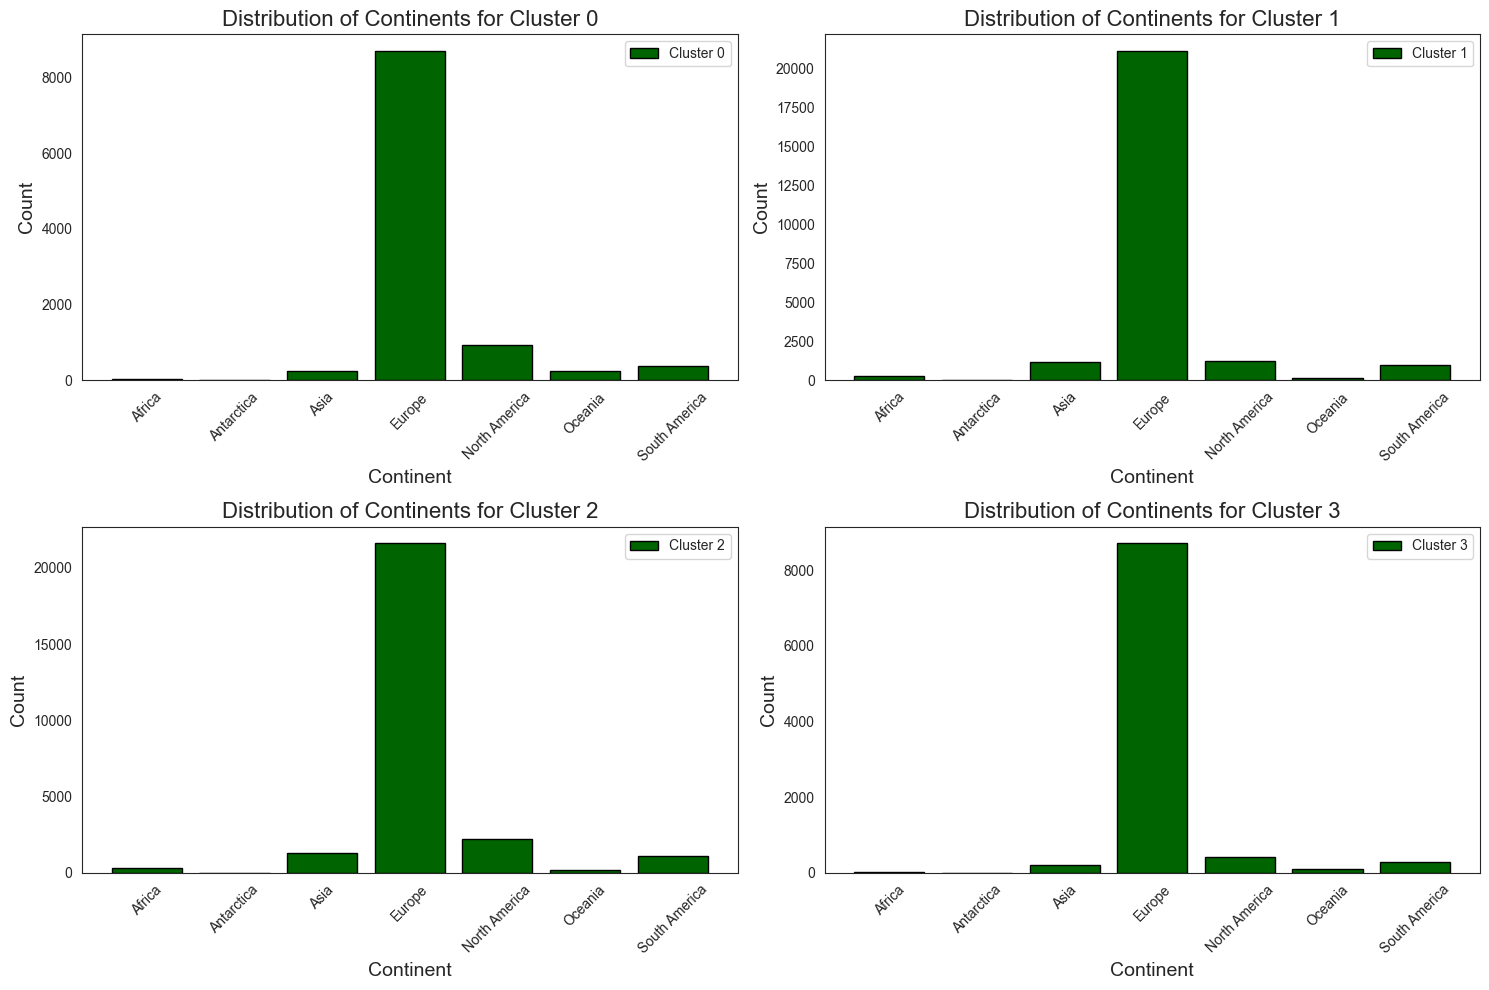

In [129]:
continent_counts = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["Continent"].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.bar(continent_counts.columns, continent_counts.loc[i], label=f"Cluster {i}", color='DarkGreen', edgecolor='black')
    ax.set_xlabel('Continent', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(f'Distribution of Continents for Cluster {i}', fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

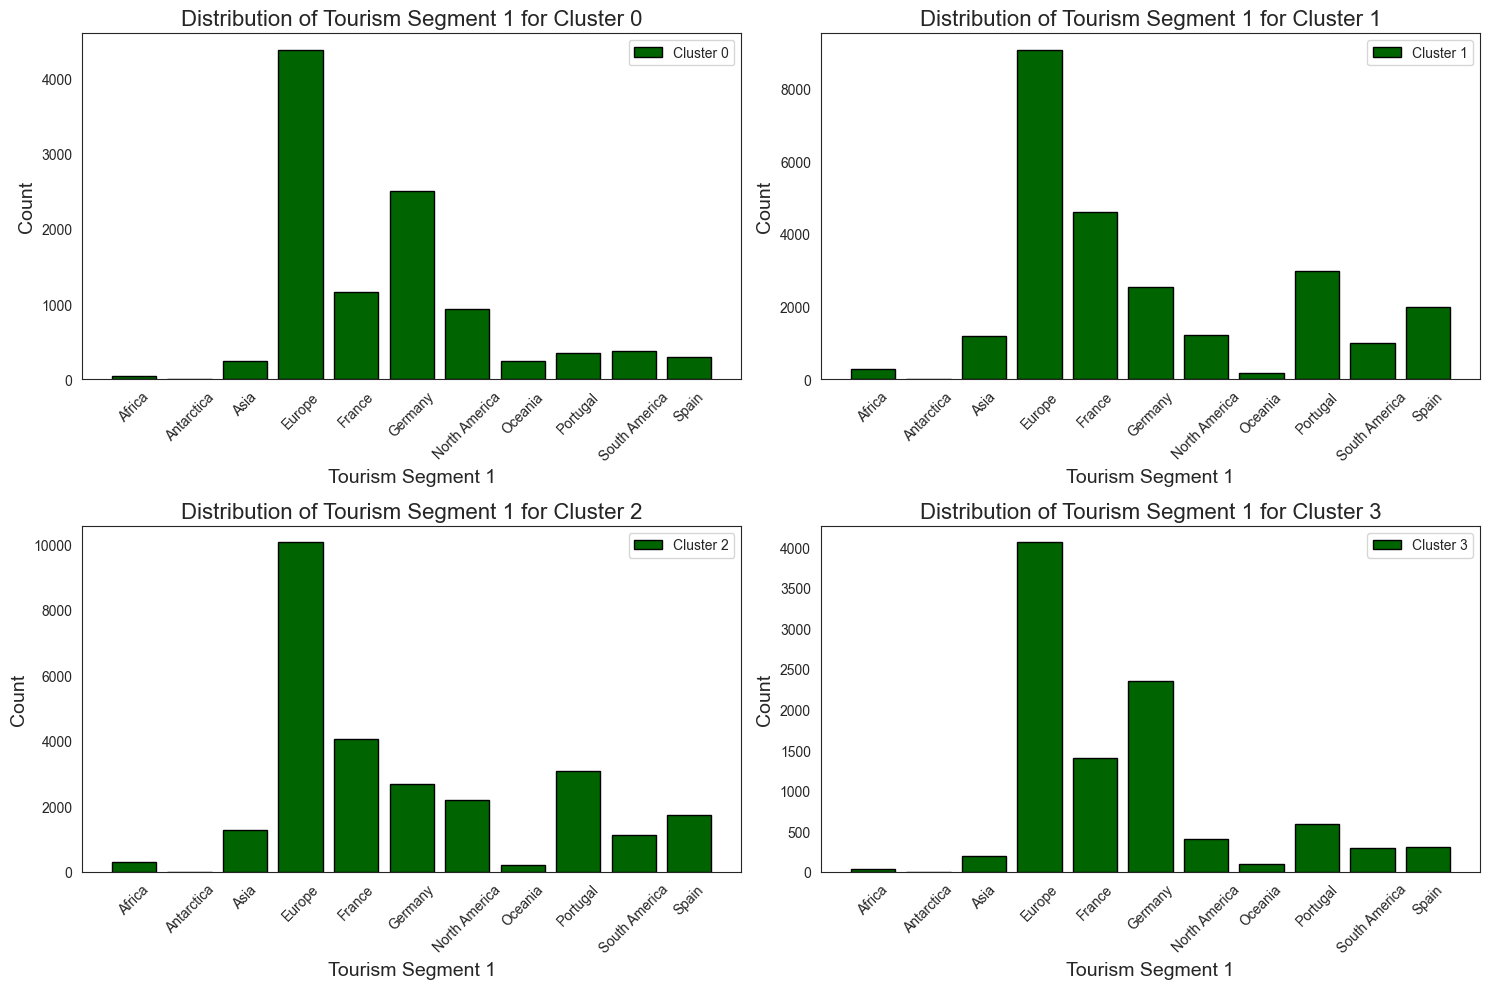

In [130]:
Geographic_segment_1_counts = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["Tourism Segment 1"].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.bar(Geographic_segment_1_counts.columns, Geographic_segment_1_counts.loc[i], label=f"Cluster {i}", color='DarkGreen', edgecolor='black')
    ax.set_xlabel('Tourism Segment 1', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(f'Distribution of Tourism Segment 1 for Cluster {i}', fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

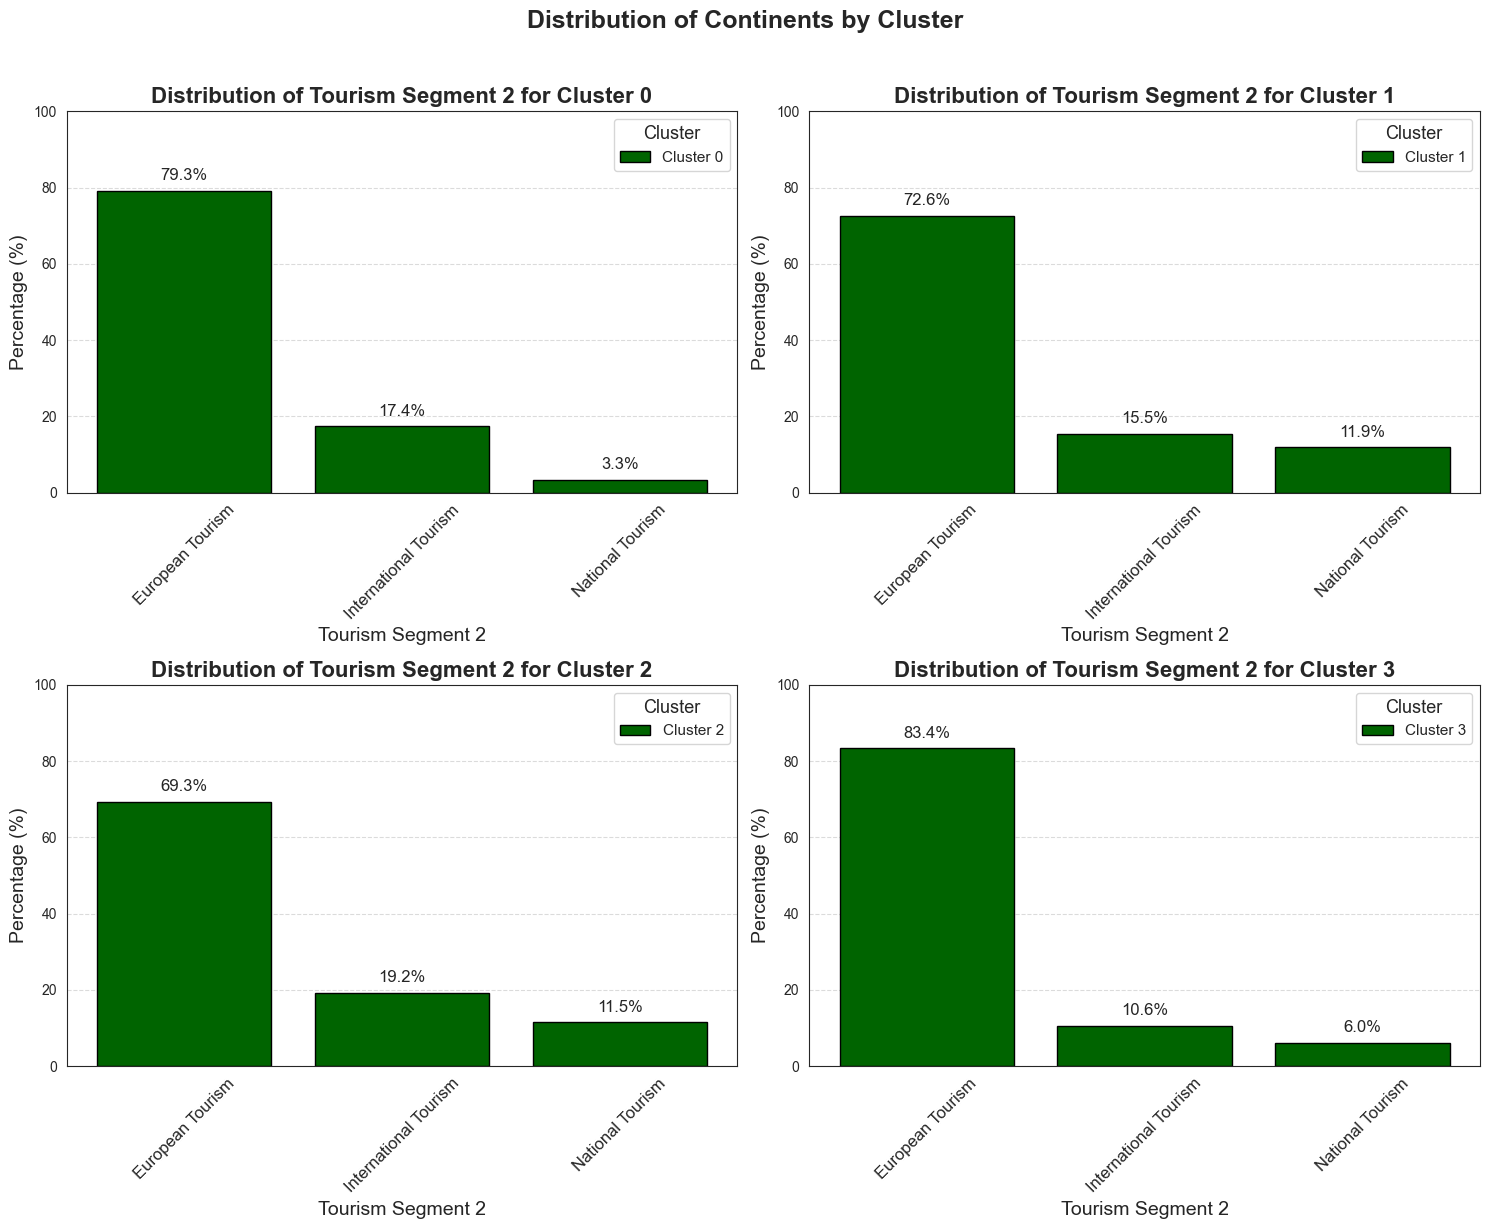

In [131]:
# Group by cluster labels and 'Tourism Segment 2' column, then count the normalized values
Geographic_segment_2_counts = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["Tourism Segment 2"].value_counts(normalize=True).unstack(fill_value=0) * 100

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through each cluster and plot
for i, ax in enumerate(axes):
    bars = ax.bar(Geographic_segment_2_counts.columns, Geographic_segment_2_counts.loc[i], label=f"Cluster {i}", color='darkgreen', edgecolor='black')
    
    # Add value labels on top of each bar
    for x, y in zip(Geographic_segment_2_counts.columns, Geographic_segment_2_counts.loc[i]):
        ax.text(x, y + 2, f'{y:.1f}%', ha='center', va='bottom', fontsize=12)  # Adjust spacing for labels

    # Set x and y labels with improved font size
    ax.set_xlabel('Tourism Segment 2', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    
    # Set title with bold font
    ax.set_title(f'Distribution of Tourism Segment 2 for Cluster {i}', fontsize=16, fontweight='bold')
    
    # Rotate x-ticks for better readability
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    
    # Make sure the y-axis starts at 0 and ends at 100 (percentage range)
    ax.set_ylim(0, 100)

    # Add gridlines for better readability of percentages
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a legend with larger font
    ax.legend(title="Cluster", title_fontsize='13', fontsize='11', loc='upper right')

# Adjust layout to prevent clipping and add a main title outside the plot
plt.suptitle("Distribution of Continents by Cluster", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

# Show the plot
plt.show()

<a class="anchor" id="distributionchannelanalysis"></a>
# [5.2.2 DistributionChannel](#Index)

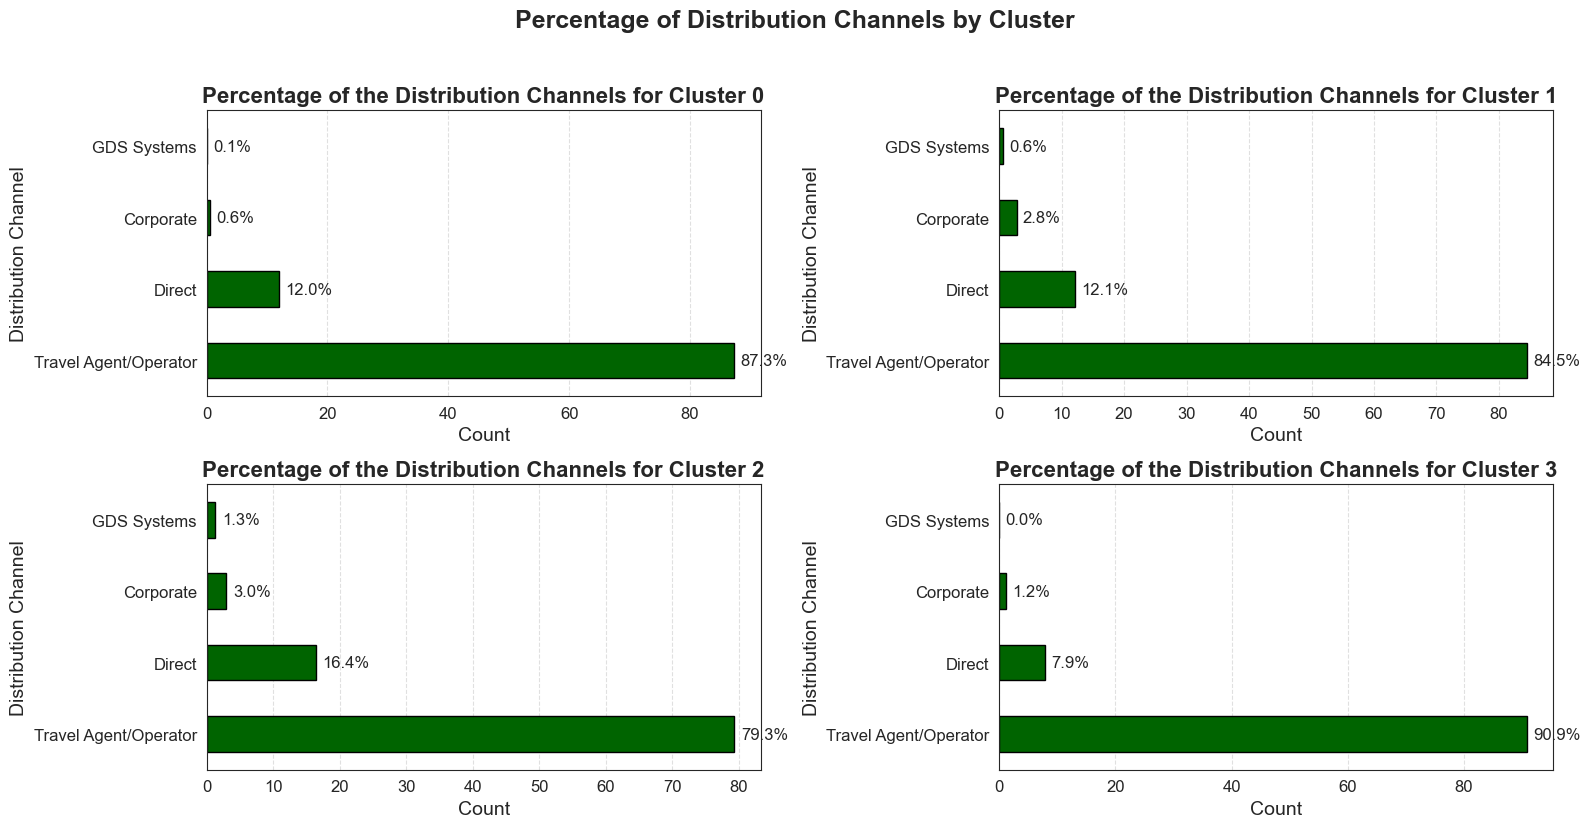

In [132]:
# Group by cluster labels and 'Distribution Channel' column, then count the values
distribution_channel_counts = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["DistributionChannel"].value_counts(normalize = True) * 100

# Create subplots with one chart per cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Increase figure size for better readability
axes = axes.flatten()

# Loop through each cluster and plot horizontal bars
for i, ax in enumerate(axes):
    # Horizontal bar chart with color palette
    distribution_channel_counts.loc[i].plot(kind='barh', ax=ax, color="darkgreen", edgecolor='black')
    
    # Add value labels on top of each bar with some adjustment to avoid overlap
    for y, x in enumerate(distribution_channel_counts.loc[i]):
        ax.text(x + 1, y, f'{x:.1f}%', va='center', fontsize=12)  # Adjust spacing for labels
    
    # Set labels and title
    ax.set_xlabel('Count', fontsize=14)
    ax.set_ylabel('Distribution Channel', fontsize=14)
    ax.set_title(f'Percentage of the Distribution Channels for Cluster {i}', fontsize=16, fontweight='bold')

    # Increase font size for y-ticks and x-ticks
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    # Add gridlines for y-axis
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Rotate y-axis labels if they are long (optional)
    ax.tick_params(axis='y', rotation=0)

# Add a general title for the entire figure
plt.suptitle('Percentage of Distribution Channels by Cluster', fontsize=18, fontweight='bold', y=1.03)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

<a class="anchor" id="requestanalysis"></a>
# [5.2.3 Request Analysis](#Index)

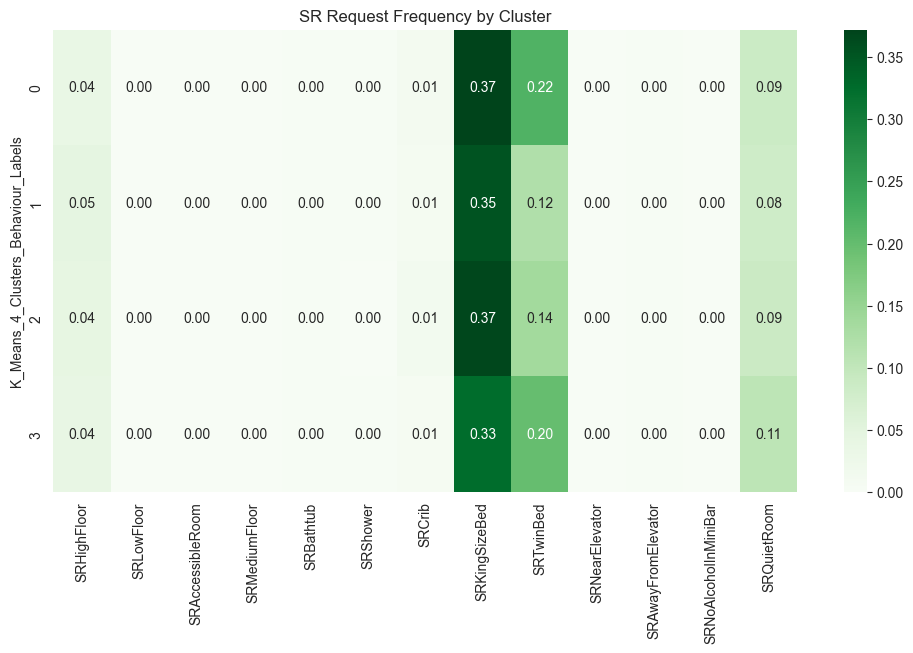

In [133]:
# Group by cluster and calculate mean for SR columns
cluster_analysis = df.groupby("K_Means_4_Clusters_Behaviour_Labels")[sr_columns].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_analysis, cmap="Greens", annot=True, fmt=".2f")
plt.title("SR Request Frequency by Cluster")
plt.show()

<a class="anchor" id="bookingwindowanalysis"></a>
# [5.2.4 Booking Window Analysis](#Index)

In [134]:
df.groupby("K_Means_4_Clusters_Behaviour_Labels")["BookingWindow"].count()

K_Means_4_Clusters_Behaviour_Labels
0    10531
1    25019
2    26760
3     9746
Name: BookingWindow, dtype: int64

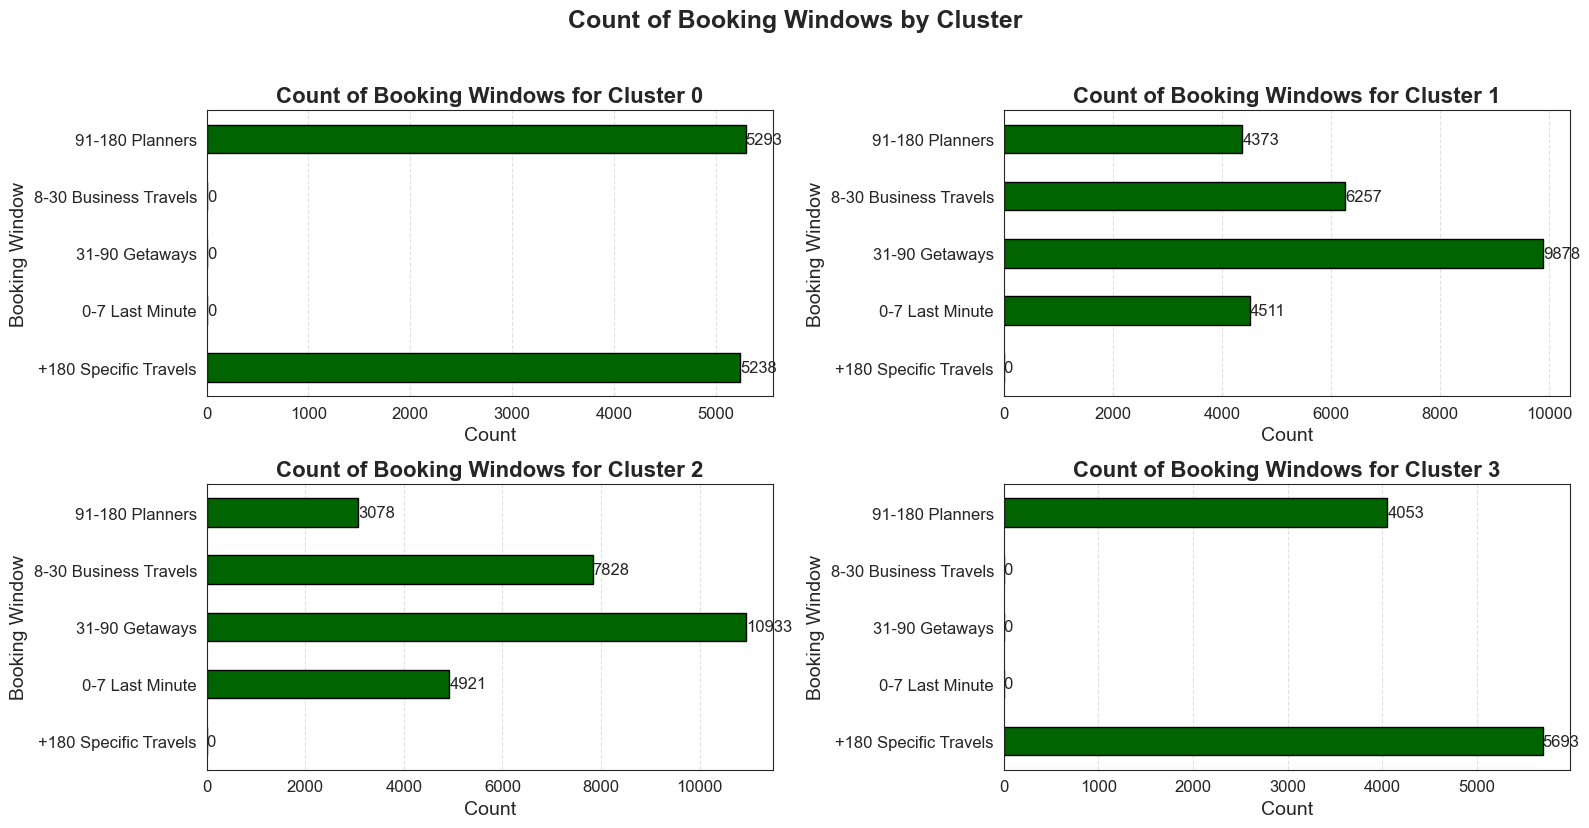

In [135]:
# Group by cluster labels and 'BookingWindow' column, then count the values
booking_window_counts = df.groupby("K_Means_4_Clusters_Behaviour_Labels")["BookingWindow"].value_counts().unstack(fill_value=0)

# Create subplots with one chart per cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Increase figure size for better readability
axes = axes.flatten()

# Loop through each cluster and plot horizontal bars
for i, ax in enumerate(axes):
    # Horizontal bar chart with color palette
    booking_window_counts.loc[i].plot(kind='barh', ax=ax, color="darkgreen", edgecolor='black')
    
    # Add value labels on top of each bar with some adjustment to avoid overlap
    for y, x in enumerate(booking_window_counts.loc[i]):
        ax.text(x + 1, y, f'{x}', va='center', fontsize=12)  # Adjust spacing for labels
    
    # Set labels and title
    ax.set_xlabel('Count', fontsize=14)
    ax.set_ylabel('Booking Window', fontsize=14)
    ax.set_title(f'Count of Booking Windows for Cluster {i}', fontsize=16, fontweight='bold')

    # Increase font size for y-ticks and x-ticks
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    # Add gridlines for y-axis
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Rotate y-axis labels if they are long (optional)
    ax.tick_params(axis='y', rotation=0)


plt.suptitle('Count of Booking Windows by Cluster', fontsize=18, fontweight='bold', y=1.03)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

We can see that the booking windows variable plays an important role in customer segmentation. Clusters 0 and 3 represent customers who tend to plan their trips in advance, as well as those who take specific-purpose trips.

On the other hand, customers in clusters 1 and 2 are those who go on getaways with little planning, as well as business travelers and last-minute travelers.

<a class="anchor" id="disengagedcustomersprofiling"></a>
# [5.3 Disengaged Customers Profiling](#Index)

In [136]:
df_disengaged = pd.read_csv("disengaged_clients.csv")

In [137]:
# Lets create the tourism segments for the disengaged clients
# Create two Geographic Segments.
1. # 5 countries from top 5 Countries with most clients, and the rest by continent
top_5_countries = [
    "Portugal", 
    "Spain", 
    "Germany", 
    "France", 
    "United Kingdom of Great Britain and Northern Ireland"
]



# Assuming country_df is your DataFrame and 'Continent' is a column in the DataFrame
df_disengaged['Tourism Segment 1'] = df_disengaged.apply(lambda row: assign_segment(row['CountryName'], row['Continent'], top_5_countries), axis=1)



2. # National Turism (PT) + European Tourism + International Tourism.



# Assuming df_disengaged is your DataFrame
df_disengaged['Tourism Segment 2'] = df_disengaged.apply(assign_tourism_type, axis=1)

df_disengaged['Tourism Segment 1'] = df_disengaged['Tourism Segment 1'].astype("category")
df_disengaged['Tourism Segment 2'] = df_disengaged['Tourism Segment 2'].astype("category")

In [138]:
df_disengaged

,ID,Nationality,Age,DaysSinceCreation,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,CountryName,Continent,Tourism Segment 1,Tourism Segment 2
0,3,DEU,32.0,1385,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,0,...,False,False,False,False,False,False,Germany,Europe,Germany,European Tourism
1,5,FRA,52.0,1385,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,0,...,False,False,False,False,False,False,France,Europe,France,European Tourism
2,7,JPN,50.0,1385,0x47E5E4B21585F1FD956C768E730604241B380EDFEA68...,0,0.0,0.0,0,0,...,False,False,False,False,False,False,Japan,Asia,Asia,International Tourism
3,9,FRA,43.0,1385,0x6C456E45A78A20BC794137AE326A81D587B6528B3944...,0,0.0,0.0,0,0,...,True,False,False,False,False,False,France,Europe,France,European Tourism
4,11,IRL,28.0,1385,0xCA46CD508DB3DB2085374141177E07ECEC4B724AE41C...,0,0.0,0.0,0,0,...,False,False,False,False,False,False,Ireland,Europe,Europe,European Tourism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31038,97875,USA,64.0,150,0xFD969E77AAA14E329FA02F6C6286C2F99BEBDE7C1D9A...,0,0.0,0.0,0,0,...,False,True,False,False,False,False,United States of America,North America,North America,International Tourism
31039,82714,PRT,59.0,299,0xFD9C7E99262F0108127B98C0EA6CED286D07789CC539...,0,0.0,0.0,0,0,...,False,True,False,False,False,False,Portugal,Europe,Portugal,National Tourism
31040,79824,PRT,52.0,338,0xFE64B981872B6F43CC192A25FAF7272BDD731B443057...,0,0.0,0.0,0,0,...,False,False,False,False,False,False,Portugal,Europe,Portugal,National Tourism
31041,75156,AUT,32.0,376,0xFF7030454BDA7429965FE5D1A803946E12B6C7A909B9...,0,0.0,0.0,0,0,...,True,False,False,False,False,False,Austria,Europe,Europe,European Tourism


<a class="anchor" id="disengagedcustomersgeographicalanalysis"></a>
# [5.3.1 Geographic Analysis](#Index)

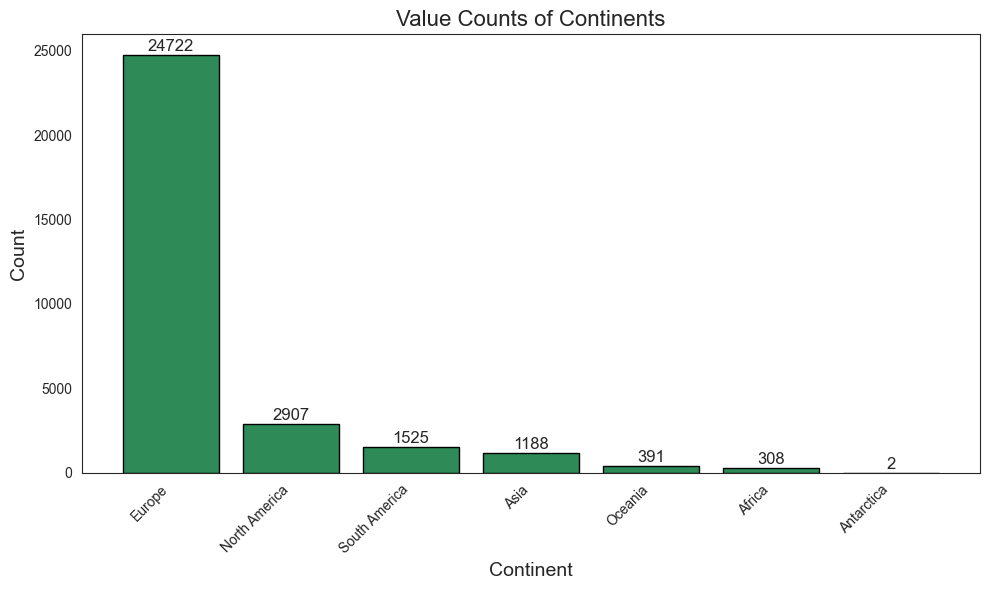

In [139]:
# Get the value counts for "Tourism Segment 1"
disengaged_continent_counts = df_disengaged["Continent"].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(disengaged_continent_counts.index, disengaged_continent_counts.values, color='seagreen', edgecolor='black')

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=12)

# Labeling the axes and the title
plt.xlabel('Continent', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Value Counts of Continents', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

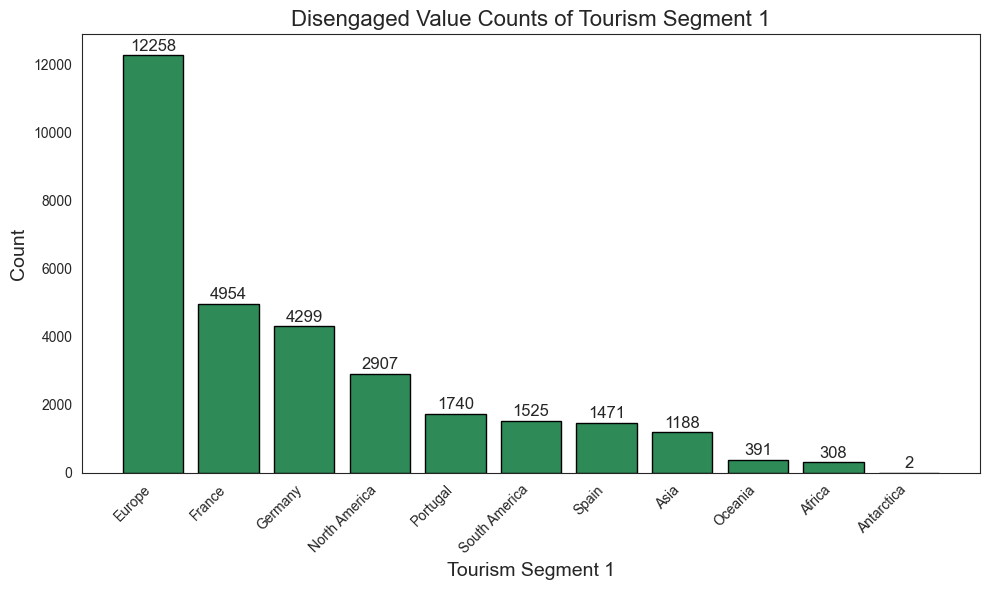

In [140]:
# Get the value counts for "Tourism Segment 1"
disengaged_tourism_segment_1_counts = df_disengaged["Tourism Segment 1"].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(disengaged_tourism_segment_1_counts.index, disengaged_tourism_segment_1_counts.values, color='seagreen', edgecolor='black')

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=12)

# Labeling the axes and the title
plt.xlabel('Tourism Segment 1', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Disengaged Value Counts of Tourism Segment 1', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

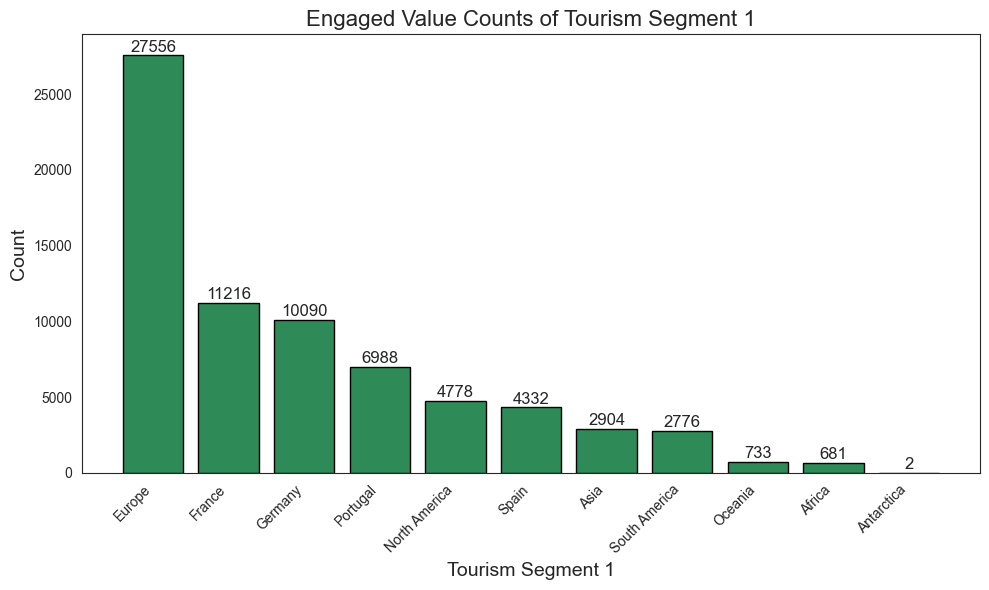

In [141]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(df["Tourism Segment 1"].value_counts().index, df["Tourism Segment 1"].value_counts().values, color='seagreen', edgecolor='black')

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=12)

# Labeling the axes and the title
plt.xlabel('Tourism Segment 1', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Engaged Value Counts of Tourism Segment 1', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

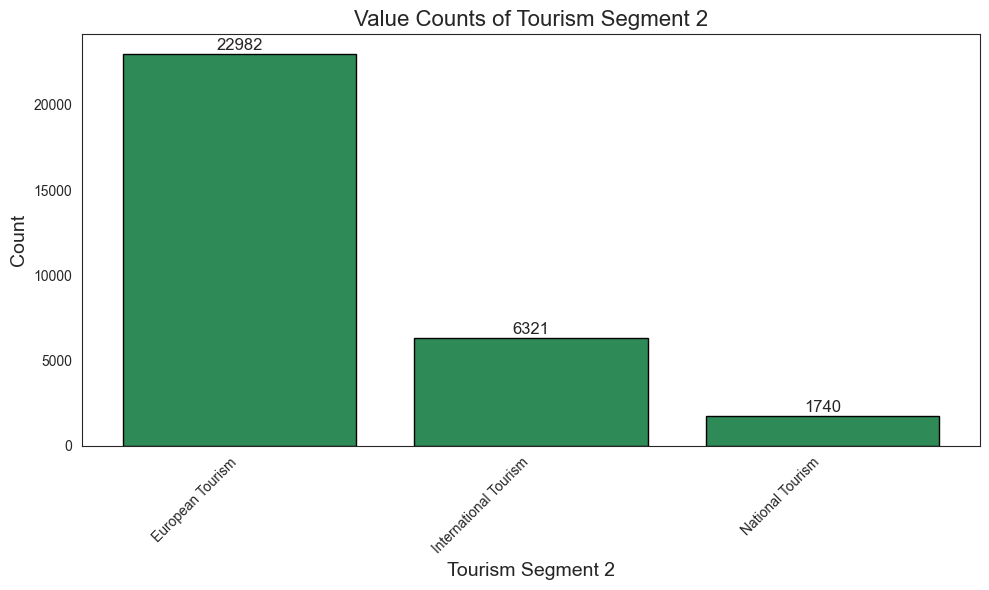

In [142]:
# Get the value counts for "Tourism Segment 1"
disengaged_tourism_segment_2_counts = df_disengaged["Tourism Segment 2"].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(disengaged_tourism_segment_2_counts.index, disengaged_tourism_segment_2_counts.values, color='seagreen', edgecolor='black')

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=12)

# Labeling the axes and the title
plt.xlabel('Tourism Segment 2', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Value Counts of Tourism Segment 2', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

<a class="anchor" id="disengagedcustomersageanalysis"></a>
# [5.3.2 Age Analysis](#Index)

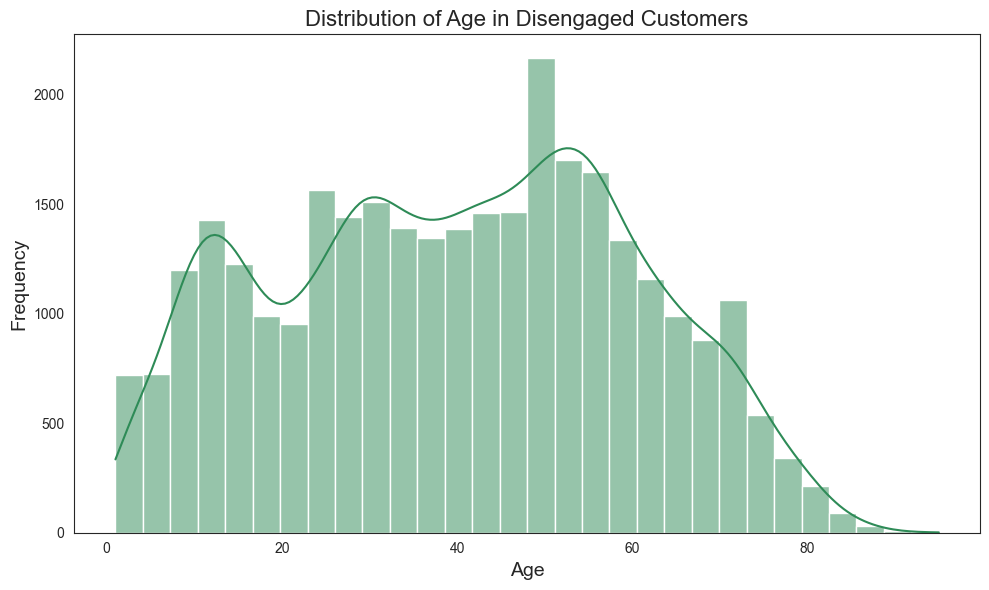

In [143]:
# Plot the distribution of the Age column
plt.figure(figsize=(10, 6))
sns.histplot(df_disengaged["Age"], kde=True, color='seagreen', bins=30)

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Age in Disengaged Customers', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

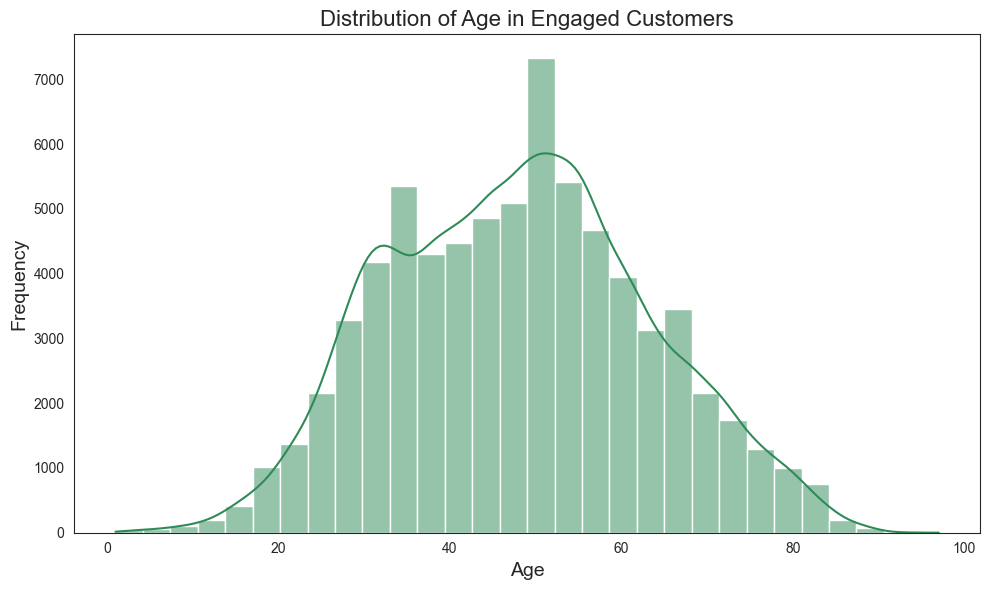

In [144]:
# Plot the distribution of the Age column
plt.figure(figsize=(10, 6))
sns.histplot(df["Age"], kde=True, color='seagreen', bins=30)

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Age in Engaged Customers', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

We can see that most of our inactive customers in the database are minors.

Since most of the customers who did not make a booking are simply creating an account, we assume that these minors under 18 are children who signed up to check prices but did not proceed because they lack purchasing power. Therefore, they are not potential customers. We will remove minors under 16 and focus on possible marketing strategies specifically for young people aged 16 to 25. For the remaining age groups, we will proceed with the analysis.

<a class="anchor" id="combiningageandgeographicalanalysis"></a>
# [5.3.3 Combining Age and Geographical Analysis](#Index)

In [145]:
df_disengaged = df_disengaged[df_disengaged["Age"] > 16]

In [146]:
# Define the bin edges and labels for df_disengaged
age_bins = [16, 25, 40, 60, 100]
age_labels = ['16-25', '26-39', '40-59', '60-100']

# Create a new column for binned Age
df_disengaged['AgeGroup'] = pd.cut(df_disengaged['Age'], bins=age_bins, labels=age_labels, right=False)

C:\Users\victo\AppData\Local\Temp\ipykernel_13372\2178210334.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disengaged['AgeGroup'] = pd.cut(df_disengaged['Age'], bins=age_bins, labels=age_labels, right=False)


In [147]:
# Define the bin edges and labels also for the df dataframe to compare with the potencial clients revenue.
age_bins = [16, 25, 40, 60, 100]
age_labels = ['16-25', '26-39', '40-59', '60-100']

# Create a new column for binned Age
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

C:\Users\victo\AppData\Local\Temp\ipykernel_13372\3364567209.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_tourism_counts = df_disengaged.groupby("AgeGroup")["Tourism Segment 2"].value_counts().unstack(fill_value=0)


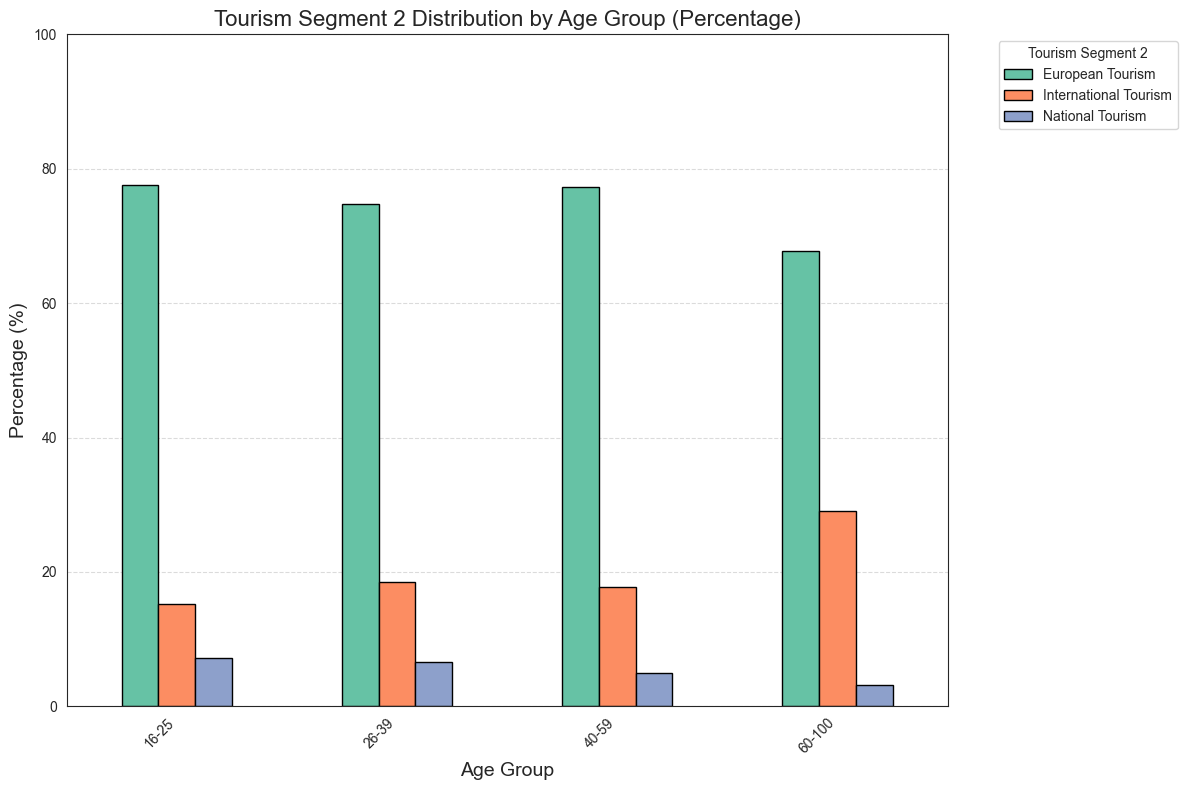

In [148]:
# Group by AgeGroup and Tourism Segment 2, then count the values
age_group_tourism_counts = df_disengaged.groupby("AgeGroup")["Tourism Segment 2"].value_counts().unstack(fill_value=0)

# Convert counts to percentages (normalize per AgeGroup)
age_group_tourism_percent = age_group_tourism_counts.div(age_group_tourism_counts.sum(axis=1), axis=0) * 100

# Set a more visually appealing color palette
colors = sns.color_palette("Set2", len(age_group_tourism_percent.columns))

# Plot the clustered column chart (side-by-side bars)
ax = age_group_tourism_percent.plot(kind='bar', figsize=(12, 8), color=colors, edgecolor='black')

# Add labels and title
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Tourism Segment 2 Distribution by Age Group (Percentage)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tourism Segment 2', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout and add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Ensure the y-axis represents percentages
plt.tight_layout()

# Show the plot
plt.show()

By this Geographical Segment there arent much conclusions to take

C:\Users\victo\AppData\Local\Temp\ipykernel_13372\1855496049.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_tourism_counts = df_disengaged.groupby("AgeGroup")["Tourism Segment 1"].value_counts().unstack(fill_value=0)
C:\Users\victo\AppData\Local\Temp\ipykernel_13372\1855496049.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_age = df[df["Nationality"].isin(selected_nationalities)].groupby(["AgeGroup", "Nationality"])["OtherRevenue"].median().unstack()
C:\Users\victo\AppData\Local\Temp\ipykernel_13372\1855496049.py:70: FutureWarning: The default of observed=False is deprecated and

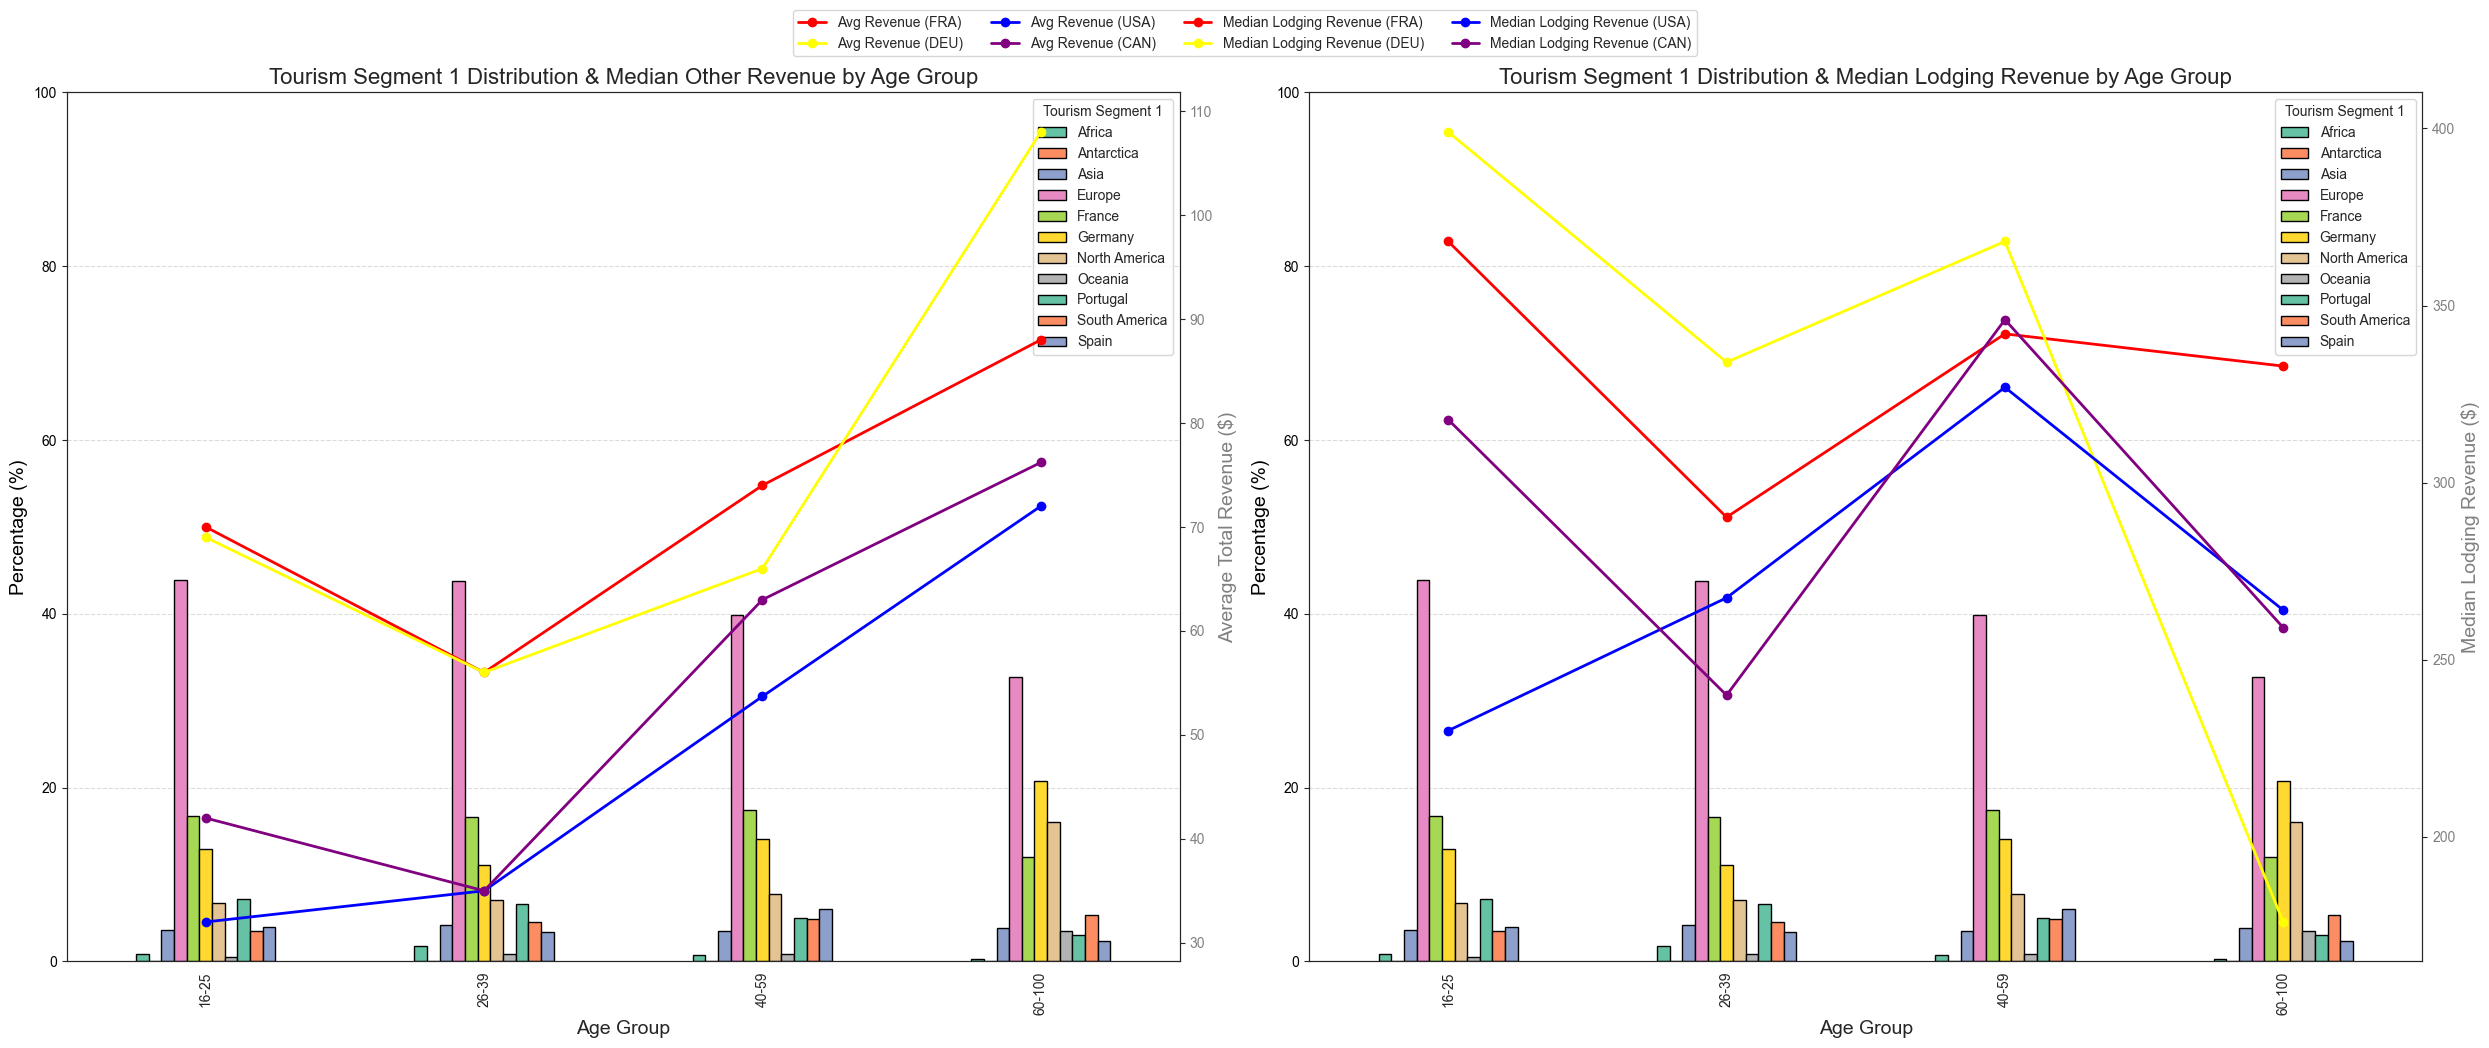

In [149]:


# Step 1: Group by AgeGroup and Tourism Segment 1, and count the values for the first plot
age_group_tourism_counts = df_disengaged.groupby("AgeGroup")["Tourism Segment 1"].value_counts().unstack(fill_value=0)

# Step 2: Convert counts to percentages (normalize per AgeGroup) for the first plot
age_group_tourism_percent = age_group_tourism_counts.div(age_group_tourism_counts.sum(axis=1), axis=0) * 100

# Set a color palette for the plots
colors = sns.color_palette("Set2", len(age_group_tourism_percent.columns))

# Step 3: Create figure and axes for two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# --------------- First Plot ---------------
# Step 4: Plot the first clustered bar chart (percentage distribution of Tourism Segment 1 by Age Group)
age_group_tourism_percent.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')

# Step 5: Customize primary y-axis for the first plot (percentage of each Tourism Segment)
ax1.set_xlabel('Age Group', fontsize=14)
ax1.set_ylabel('Percentage (%)', fontsize=14, color='black')
ax1.set_title('Tourism Segment 1 Distribution & Median Other Revenue by Age Group', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Step 6: Improve the layout and add gridlines for the first plot
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 100)  # Ensure the y-axis represents percentages

# Step 7: Create a secondary y-axis for the first plot (Average Revenue Trend)
ax1_secondary = ax1.twinx()
# Filter the dataframe for selected nationalities and calculate average revenue per AgeGroup
selected_nationalities = ["FRA", "DEU", "USA", "CAN"]
revenue_by_age = df[df["Nationality"].isin(selected_nationalities)].groupby(["AgeGroup", "Nationality"])["OtherRevenue"].median().unstack()

# Define colors for each nationality for clarity in the first plot
nationality_colors = {
    "FRA": "red",  # France
    "DEU": "yellow",  # Germany
    "USA": "blue",  # United States
    "CAN": "purple"  # Canada
}

# Plot revenue trend by AgeGroup for each nationality in the first plot
handles, labels = [], []  # Store handles and labels for the combined legend
for nationality, color in nationality_colors.items():
    if nationality in revenue_by_age.columns:
        line, = ax1_secondary.plot(revenue_by_age.index, revenue_by_age[nationality], marker='o', linestyle='-', color=color, linewidth=2, label=f'Avg Revenue ({nationality})')
        handles.append(line)  # Collect line handles for legend
        labels.append(f'Avg Revenue ({nationality})')

# Customize secondary y-axis for the first plot
ax1_secondary.set_ylabel('Average Total Revenue ($)', fontsize=14, color='gray')
ax1_secondary.tick_params(axis='y', labelcolor='gray')

# --------------- Second Plot ---------------
# Step 8: Plot the second clustered bar chart (percentage distribution of Tourism Segment 1 by Age Group)
age_group_tourism_percent.plot(kind='bar', ax=ax2, color=colors, edgecolor='black')

# Step 9: Customize primary y-axis for the second plot (percentage of each Tourism Segment)
ax2.set_xlabel('Age Group', fontsize=14)
ax2.set_ylabel('Percentage (%)', fontsize=14, color='black')
ax2.set_title('Tourism Segment 1 Distribution & Median Lodging Revenue by Age Group', fontsize=16)
ax2.tick_params(axis='y', labelcolor='black')

# Step 10: Improve the layout and add gridlines for the second plot
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_ylim(0, 100)  # Ensure the y-axis represents percentages

# Step 11: Create a secondary y-axis for the second plot (Median Lodging Revenue Trend)
ax2_secondary = ax2.twinx()
# Filter the dataframe for selected nationalities and calculate median lodging revenue per AgeGroup
revenue_by_age_lodging = df[df["Nationality"].isin(selected_nationalities)].groupby(["AgeGroup", "Nationality"])["LodgingRevenue"].median().unstack()

# Plot lodging revenue trend by AgeGroup for each nationality in the second plot
for nationality, color in nationality_colors.items():
    if nationality in revenue_by_age_lodging.columns:
        line, = ax2_secondary.plot(revenue_by_age_lodging.index, revenue_by_age_lodging[nationality], marker='o', linestyle='-', color=color, linewidth=2, label=f'Median Lodging Revenue ({nationality})')
        handles.append(line)  # Collect line handles for legend
        labels.append(f'Median Lodging Revenue ({nationality})')

# Customize secondary y-axis for the second plot
ax2_secondary.set_ylabel('Median Lodging Revenue ($)', fontsize=14, color='gray')
ax2_secondary.tick_params(axis='y', labelcolor='gray')

# Step 12: Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Step 13: Combine all the handles and labels from both plots into a single legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)

# Step 14: Display the plot with the improved layout
plt.tight_layout()
plt.show()


In [150]:
# Get the n largest values for each AgeGroup
n = 10  # Specify the number of largest values you want for each group
largest_values = df_disengaged.groupby("AgeGroup")["Nationality"].value_counts().groupby(level=0, group_keys=False).nlargest(n)
pd.DataFrame(largest_values)

C:\Users\victo\AppData\Local\Temp\ipykernel_13372\2078357290.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest_values = df_disengaged.groupby("AgeGroup")["Nationality"].value_counts().groupby(level=0, group_keys=False).nlargest(n)
C:\Users\victo\AppData\Local\Temp\ipykernel_13372\2078357290.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest_values = df_disengaged.groupby("AgeGroup")["Nationality"].value_counts().groupby(level=0, group_keys=False).nlargest(n)


count
AgeGroup Nationality       
16-25    FRA            446
         DEU            345
         GBR            226
         PRT            192
         NLD            190
         BEL            179
         USA            139
         ESP            107
         ITA             85
         CHE             84
26-39    FRA           1156
         GBR            912
         DEU            778
         PRT            464
         USA            357
         IRL            334
         BRA            284
         BEL            262
         NLD            250
         ESP            236
40-59    FRA           1797
         DEU           1452
         GBR            987
         ESP            619
         PRT            512
         USA            497
         BEL            482
         BRA            445
         ITA            445
         NLD            392
60-100   DEU           1183
         GBR            752
         FRA            689
         USA            561
         CAN            329
         BRA            257
         ITA            210
         AUS            179
         PRT            177
         NLD            135

Through the analysis of disengaged customers, we can observe that potential guests at our hotel exhibit varying demographic characteristics, particularly in terms of age and nationality.

Initially, we removed customers under the age of 16 from the analysis, as we assumed they did not possess the purchasing power to fully engage with our hotel’s services. 

Our analysis was based on studying potential customers and their nationalities, specifically evaluating how similar nationalities that have already stayed at our hotel behave in terms of spending. The data reflects how these specific nationalities have spent at our hotel, providing us with a better understanding of the potential spending patterns of future guests.

In a global analysis, we found that potential European clients, especially French nationals, show consistent behavior across all age groups. French potencial guests maintain their presence across various age ranges and the french guests that stayed in our hotel have also the highest spenders throughout these different age categories. 

However, starting from the age of 40, we observe a significant increase in potential German and North American clients, with a notable rise in the number of U.S. and Canadian guests beyond the age of 60. Unlike the French, these three nationalities (German, U.S., and Canadian) do not show consistent spending patterns. By analysing our the customers that did chedked in, qe can say that by the age of 40 onward, there is a sharp decline in lodging expenses, particularly among German clients, indicating that these nationalities spend less on accommodation as they age. However, there is a significant increase in their spending on "Other Revenues," which suggests that they are more likely to spend money on non-accommodation services such as dining, spa treatments, and other hotel amenities.

This analysis suggests that, starting around the age of 40 to 60, there is a potential market of new customers from Germany, the U.S., and Canada. These customers, based on previous guests of these same nationalities, tend to increase their spending on "Other Revenues" compared to other age groups. On the other hand, potential European customers, particularly the French, exhibit a more stable and consistent spending behavior across different age groups.

## Summary Analysis

### **Cluster 0: High-Spending, High-Frequency Guests**
- **Age Group**: Guests span all age groups, with a concentration in the 30-50 age range, showing a preference for quality services.
- **Revenue**: High revenue per booking ($597) and lodging revenue ($510).
- **Frequency**: Visit the most frequently, with an average frequency of 286 days.
- **Booking Lead Time**: Moderate booking lead time (191 days).
- **Segment**: Planners and Specific Travelers.

### **Cluster 1: Infrequent Visitors, Budget-Conscious, Last-Minute Travel**
- **Age Group**: Typically younger, 20-35 years, prioritizing spontaneous trips.
- **Revenue**: Lowest revenue per booking ($440) and lodging revenue ($358).
- **Frequency**: Visit the least frequently, with an average of 1041 days.
- **Other Revenue**: Minimal other revenue ($83), indicating budget-conscious travelers.
- **Booking Lead Time**: Very short booking lead time (46 days), indicating last-minute bookings.
- **Segment**: Business Travelers, Getaways, and Last-Minute Travelers.

### **Cluster 2: Frequent Visitors, Moderate-Spending, Last-Minute Travel**
- **Age Group**: Typically younger, 20-35 years, prioritizing spontaneous trips.
- **Revenue**: Moderate revenue per booking ($481) and lodging revenue ($440).
- **Frequency**: Visit more frequently (381 days).
- **Other Revenue**: Low other revenue ($87), suggesting focus on lodging.
- **Booking Lead Time**: Short booking lead time (40 days), suggesting last-minute travel.
- **Segment**: Business Travelers, Getaways, and Last-Minute Travelers.

### **Cluster 3: Infrequent Visitors, High Other-Revenue Spenders, High-Planning**
- **Age Group**: Guests span all age groups, with a concentration in the 30-50 age range, showing a preference for quality services.
- **Revenue**: Moderate revenue per booking ($498) and lodging revenue ($389), high other revenue ($109).
- **Frequency**: Visits infrequently (927 days).
- **Other Revenue**: High, indicating spending on hotel amenities beyond lodging.
- **Booking Lead Time**: Long booking lead time (214 days), indicating planning.
- **Segment**: Planners and Specific Travelers.

### **Cluster 4: Disengaged but Potential Customers**
- **Age 40 and Above**:
  - Significant increase in potential **German**, **U.S.**, and **Canadian** clients.
  - Notable rise in **U.S.** and **Canadian** guests beyond **age 60**.

- **Spending Patterns**:
  - **German, U.S., and Canadian clients** do not show consistent spending across age groups.
  - From age **40 onwards**, there is a sharp **decline in lodging expenses**, particularly for **German** clients.
  - However, there is a significant increase in spending on **"Other Revenues"** (e.g., dining, spa, amenities).

- **Market Opportunity**:
  - **Potential new customer base** for **Germany**, **U.S.**, and **Canada** from ages **40-60**.
  - These clients tend to spend more on **"Other Revenues"** compared to other age groups.

- **French Clients**:
  - **Stable and consistent spending behavior** across all age groups.
  - French potential customers maintain their presence and spending patterns throughout various age categories.


## Note

For the first four clusters we saw that the geographical segments, distribution channel and total requests didnt had value to the first 4 clusters.
